#Installing packages and libraries


In [1]:
!pip install statsmodels
!pip install pandas-datareader
!pip install --upgrade pandas-datareader
!pip install arch
!pip install pmdarima

# Importing libraries
import warnings
warnings.simplefilter('ignore')
import arch
from pmdarima import auto_arima
import math
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

# Data Handling
import pandas as pd
import numpy as np

# Statistics
import statsmodels.api as sm
from statsmodels.compat import lzip
from statsmodels.api import OLS
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.graphics.tsaplots import acf as acf_func
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.vector_ar.vecm import VECM
from statsmodels.tsa.vector_ar import irf
from statsmodels.tsa.api import VAR
from statsmodels.tools.eval_measures import rmse, aic
from statsmodels.stats.stattools import durbin_watson

# Data Visualisation
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 916.4/916.4 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 8.0 MB/s eta 0:00:00


#Loading the data

In [2]:
# Load the data from csv file
dataset = pd.read_csv('/content/merged_data_with_datetime (1).csv')

# Rename the 'Unnamed: 0' column to 'Date'
dataset.rename(columns={'Unnamed: 0': 'Date'}, inplace=True)

# Convert 'Date' column to datetime format
dataset['Date'] = pd.to_datetime(dataset['Date'])

# Set 'Date' column as the index
dataset.set_index('Date', inplace=True)

# Rename each column of the variables to make them more readable
dataset.rename(columns={
    "S&P Cryptocurrency Broad Digital Market Index (USD)": "Crypto",
    "Close": "SP500",
    "GBPJPY=X": "GBPJPY",
    "EURCAD=X": "EURCAD",
    "AUDCNY=X": "AUDCNY",
    "Int_rates": "Interest_Rates",
    "Inflation": "CPI",
    "News_Based_Policy_Uncert_Index": "EPU"
}, inplace=True)

# Display the updated dataset
dataset.head()

,SP500,GBPJPY,EURCAD,AUDCNY,Crypto,Interest_Rates,CPI,EPU
Date,,,,,,,,
2017-03-01,2395.959961,139.951996,1.40673,5.2413,102.93,0.62,0.081280,155.000000
2017-03-02,2381.919922,140.024002,1.40652,5.2627,108.62,0.66,0.088224,155.096774
2017-03-03,2383.120117,140.337006,1.40678,5.2084,108.78,0.70,0.095168,155.193548
2017-03-06,2375.310059,140.014999,1.42111,5.2307,108.92,0.73,0.116001,155.483871
2017-03-07,2368.389893,139.427994,1.41759,5.2269,105.78,0.75,0.122946,155.580645


In [3]:
description = dataset.describe()
description

,SP500,GBPJPY,EURCAD,AUDCNY,Crypto,Interest_Rates,CPI,EPU
count,1541.000000,1539.000000,1539.000000,1541.000000,1541.000000,1541.000000,1541.000000,1541.000000
mean,3346.224342,147.751702,1.478226,4.839857,1612.190928,1.425328,0.297520,194.205977
std,708.223569,9.720822,0.062996,0.201305,1453.469684,1.295279,0.342862,74.140767
min,2237.399902,125.961998,1.289990,4.076592,98.740000,-0.050000,-0.668694,110.000000
25%,2743.149902,140.260002,1.450190,4.708164,581.930000,0.120000,0.059032,149.677419
50%,3122.870117,147.110992,1.486250,4.814400,907.640000,1.290000,0.256918,170.400000
75%,3981.350098,153.828499,1.520750,4.977717,2129.040000,2.150000,0.493421,207.516129
max,4796.560059,171.376007,1.613780,5.396700,6215.990000,5.060000,1.373608,504.000000


Now, we convert the all the variables (except for the CPI as it is already a percentage change) to returns and compare the descriptive statistics again.

The advantage of generating the returns is that it will make it easier to compare the variables. This is because the returns will be expressed as a percentage change, which is a standardized metric.

The disadvantage of generating the returns is that it will lose some of the information in the original data. For example, the original data may contain the absolute price of the cryptocurrency, but the returns will only contain the percentage change in the price.

Overall, the advantages of generating the returns outweigh the disadvantages. This is because it will make it easier to compare the variables and identify any relationships between them.

Here are some additional thoughts on the advantages and disadvantages of generating returns:

Advantages:

* Makes it easier to compare variables on a like-for-like basis.
* Can help to identify relationships between variables.
* Can be used to calculate other metrics, such as volatility and risk.

However, we must first remove CPI from the dataset before taking returns on the rest of the variables since it is already a growth rate of the previous period.

In [4]:
CPI = dataset['CPI']
return_dataset = dataset.drop('CPI', axis=1)
return_dataset = return_dataset.pct_change()
return_dataset.tail()

,SP500,GBPJPY,EURCAD,AUDCNY,Crypto,Interest_Rates,EPU
Date,,,,,,,
2023-04-24,0.000852,0.000288,0.006195,-0.004429,0.003569,0.012048,0.020870
2023-04-25,-0.015811,0.005122,0.005808,0.001996,0.004431,-0.013889,0.006814
2023-04-26,-0.003841,-0.009589,-0.000916,-0.004962,0.002957,0.006036,0.006768
2023-04-27,0.019566,0.002609,0.007017,-0.004475,0.055734,0.006000,0.006723
2023-04-28,0.008253,0.003966,-0.003494,0.002612,-0.013695,-0.015905,0.006678


Now, let's merge the CPI back into the converted dataset. To make the data more consistent, we will divide the CPI by 100 to show a percentage change.

In [5]:
# Divide the CPI column by 100
CPI = CPI / 100
return_dataset = pd.merge(return_dataset, CPI, left_index=True, right_index=True)

In [6]:
# Check for missing values
print(return_dataset.isnull().sum())

SP500             1
GBPJPY            1
EURCAD            1
AUDCNY            1
Crypto            1
Interest_Rates    1
EPU               1
CPI               0
dtype: int64


In [7]:
return_dataset.loc['2017-03-01', 'CPI'] = pd.NA
return_dataset = return_dataset.dropna()
return_dataset = return_dataset.dropna(subset=['CPI'])

#Explanatory Data Analysis

In [8]:
description = return_dataset.describe()
description

,SP500,GBPJPY,EURCAD,AUDCNY,Crypto,Interest_Rates,EPU,CPI
count,1540.000000,1540.000000,1540.000000,1540.000000,1540.000000,1540.000000,1540.000000,1540.000000
mean,0.000441,0.000136,0.000052,-0.000065,0.003177,0.006838,0.000286,0.002977
std,0.012742,0.006477,0.004628,0.006607,0.048398,0.216573,0.015295,0.003429
min,-0.119841,-0.038425,-0.024274,-0.029262,-0.241241,-5.000000,-0.105194,-0.006687
25%,-0.004007,-0.003415,-0.002832,-0.004071,-0.019574,-0.007390,-0.006615,0.000590
50%,0.000751,0.000144,0.000052,-0.000059,0.002578,0.000000,0.000807,0.002575
75%,0.006412,0.003797,0.002748,0.003748,0.028612,0.009674,0.007473,0.004937
max,0.093828,0.031016,0.031705,0.036026,0.206094,3.000000,0.093396,0.013736


The inferential analysis provides descriptive statistics for each variable in the dataset. Here are the key observations from the summary:

1. count: This is the number of data points available for each variable. It indicates that you have 1540 data points for each variable.

2. mean: The mean (average) value of the variable. For example, the mean Crypto value is approximately 0.003177.

3. std: The standard deviation, which measures the dispersion or spread of the data around the mean. A higher standard deviation indicates more variability in the data.

4. min: The minimum value observed in the dataset for each variable.

5. 25%: The 25th percentile, also known as the first quartile. This is the value below which 25% of the data points fall.

6. 50%: The 50th percentile, also known as the median. This is the value below which 50% of the data points fall.

7. 75%: The 75th percentile, also known as the third quartile. This is the value below which 75% of the data points fall.

8. max: The maximum value observed in the dataset for each variable.

Overall, the summary helps us understand the central tendency, variability, and range of each variable in the dataset, which is essential for further analysis and interpretation.

Let's plot the original dataset and the converted dataset:

<Axes: title={'center': 'Plotting of raw data'}, xlabel='Date'>

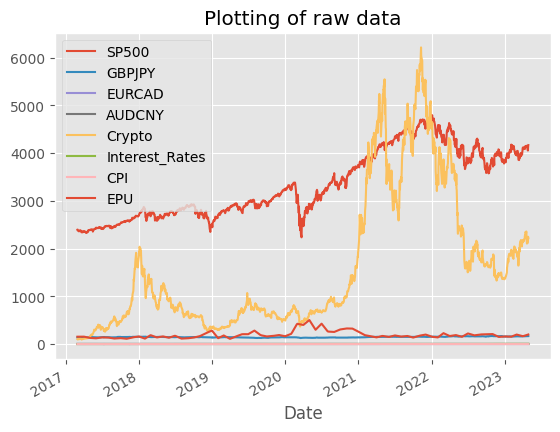

In [9]:
dataset.plot(legend=True,title="Plotting of raw data")

<Axes: title={'center': 'Plotting of returns data'}, xlabel='Date'>

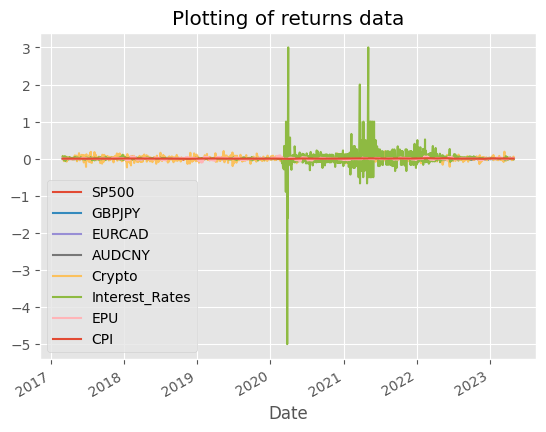

In [10]:
return_dataset.plot(legend=True,title="Plotting of returns data")

Correlation test aganist the returns variables

In [11]:
returns = return_dataset
variables = returns[['Crypto',	'SP500',	'GBPJPY',	'EURCAD',	'AUDCNY',	'Interest_Rates',	'CPI',	'EPU']]

##Correlation heatmap

A correlation heatmap can be used to quickly visualize the relationships between multiple variables. This can be helpful for identifying variables that are strongly correlated, which can be useful for further analysis.

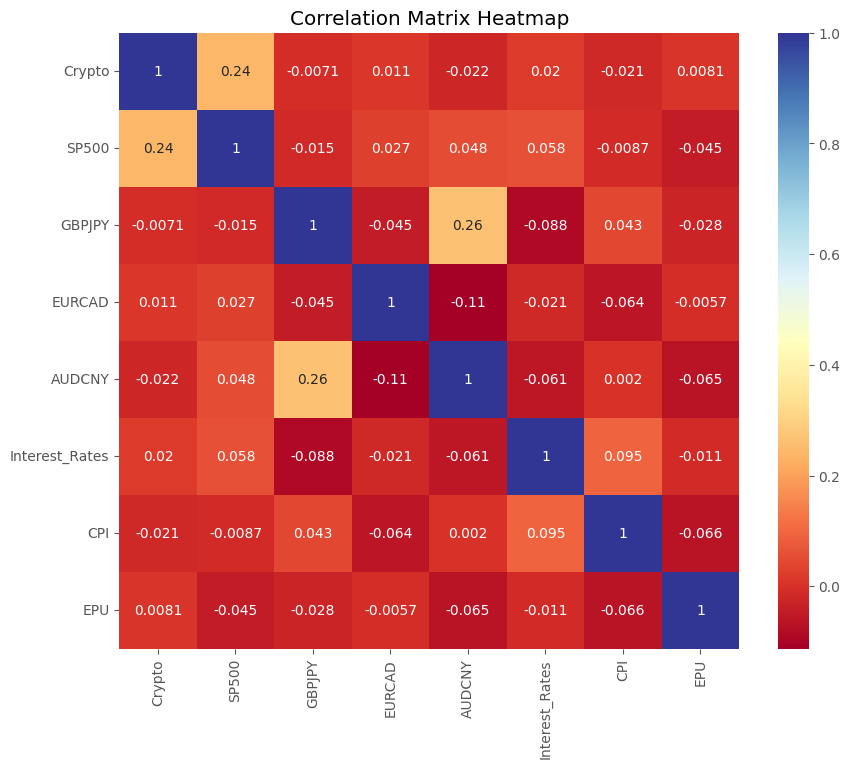

In [12]:
# Compute the correlation matrix
corr_matrix = return_dataset[['Crypto',	'SP500',	'GBPJPY',	'EURCAD',	'AUDCNY',	'Interest_Rates',	'CPI',	'EPU']].corr()

# Create the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='RdYlBu')
plt.title('Correlation Matrix Heatmap')
plt.show()

As we can see, the correlation coefficients are close to zero, which means that the variables are not quite significant. To confirm our results, we will then contstruct a simple OLS regression.

##Simple OLS regression

In [13]:
# Perform a linear regression to explore the relationship
# Define the dependent variable (y) and independent variable(s) (X)
y = return_dataset['Crypto']
X = return_dataset.drop('Crypto', axis=1)

# Add a constant column to X for the intercept term
X = sm.add_constant(X)

# Fit the OLS regression model
model = sm.OLS(y, X)
results = model.fit()

# Get the residuals from the model
residuals = results.resid

# Print the regression results summary
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                 Crypto   R-squared:                       0.061
Model:                            OLS   Adj. R-squared:                  0.056
Method:                 Least Squares   F-statistic:                     14.13
Date:                Thu, 10 Aug 2023   Prob (F-statistic):           7.22e-18
Time:                        10:54:36   Log-Likelihood:                 2527.1
No. Observations:                1540   AIC:                            -5038.
Df Residuals:                    1532   BIC:                            -4995.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.0035      0.002      2.

The results from our OLS regression further confirms the insignificance of the independent variables:

1. **R-squared**: R-squared measures the proportion of the variance in the dependent variable (Crypto) that can be explained by the independent variables. In this case, the R-squared value is 0.061, indicating that about 6.1% of the variance in Crypto can be explained by the included independent variables.

2. **Adj. R-squared**: The adjusted R-squared takes into account the number of independent variables in the model and provides a better measure of model fit. It's similar to R-squared but penalizes the addition of unnecessary variables. Here, the adjusted R-squared is 0.056.

3. **F-statistic**: The F-statistic tests the overall significance of the regression model. A larger F-statistic and a smaller associated probability (Prob (F-statistic)) indicate that at least one of the independent variables is significantly related to the dependent variable. Here, the F-statistic is 14.13, and the very small p-value (7.22e-18) suggests that the model as a whole is statistically significant.

4. **Coefficients**: The coefficients represent the estimated impact of each independent variable on the dependent variable, holding other variables constant. For example, a unit change in SP500 is associated with a 0.9287 change in the Crypto variable.

5. **P-values**: In this case, the SP500 variable has a very low p-value (0.000), indicating it is likely a significant predictor. Other variables such as GBPJPY, EURCAD, AUDCNY, Interest_Rates, EPU, and CPI do not appear to be statistically significant in predicting Crypto.

##Check for Multicollinearity

In [14]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

X = return_dataset[['Crypto',	'SP500',	'GBPJPY',	'EURCAD',	'AUDCNY',	'Interest_Rates',	'CPI',	'EPU']]
vif_data = pd.DataFrame()
vif_data['Feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif_data)

          Feature       VIF
0          Crypto  1.065818
1           SP500  1.074188
2          GBPJPY  1.084112
3          EURCAD  1.016916
4          AUDCNY  1.097006
5  Interest_Rates  1.023066
6             CPI  1.015419
7             EPU  1.008165


The Variance Inflation Factor (VIF) is a measure used to detect multicollinearity in a multiple regression model. It quantifies how much the variance of an estimated regression coefficient increases due to collinearity among the predictor variables.

Since all the VIF values are close to 1, it indicates that there is **no significant multicollinearity** among the features in the regression model. This is good news, as it suggests that the predictor variables are not excessively correlated, and the model's coefficient estimates are likely to be stable and reliable.

##Check for Autocorrelation

Durbin-Watson Test Result: 2.019698882375079


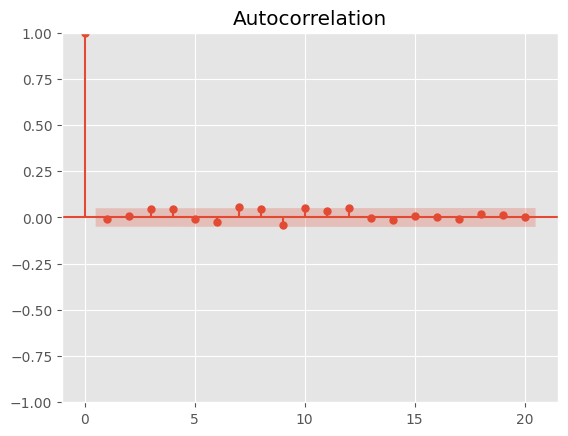

In [15]:
import statsmodels.api as sm
import statsmodels.graphics.tsaplots as tsaplots

# Assuming 'residuals' is the residual series from the regression model
residuals = residuals.reset_index(drop=True)

# Plot autocorrelation of residuals
tsaplots.plot_acf(residuals, lags=20)

# Perform the Durbin-Watson test for autocorrelation
dw_test_result = sm.stats.durbin_watson(residuals)

print('Durbin-Watson Test Result:', dw_test_result)

The ACF shows a significant peak at lag 1, which suggests that there is some first-order autocorrelation in the data. This means that the current value of the returns is correlated with the previous value.

##Check for Heteroscedasticity

In [16]:
from statsmodels.stats.diagnostic import het_breuschpagan

# Assuming 'residuals' is the residual series from our regression model
bp_test_results = het_breuschpagan(residuals, X)
print('Breusch-Pagan Test Results:')
print('Lagrange Multiplier Statistic:', bp_test_results[0])
print('LM-Test p-value:', bp_test_results[1])
print('F-Statistic:', bp_test_results[2])
print('F-Test p-value:', bp_test_results[3])

Breusch-Pagan Test Results:
Lagrange Multiplier Statistic: 99.88769291161856
LM-Test p-value: 1.137972801540185e-18
F-Statistic: 13.282639901362222
F-Test p-value: 1.0699340655424746e-18


The Breusch-Pagan test is a test for heteroskedasticity in a regression model. Heteroskedasticity occurs when the variance of the residuals is not constant across all levels of the independent variables, which can violate the assumption of homoskedasticity required for Ordinary Least Squares (OLS) regression.

In summary, the Breusch-Pagan test results strongly suggest that **there is heteroscedasticity** in the regression model. This means that the variability of the residuals changes as the independent variable(s) change, which can have implications for the reliability and validity of the regression analysis. It might be necessary to address this heteroscedasticity before making further interpretations or decisions based on the regression model.

Some of the main consequences of heteroscedasticity include:

* Inefficient and Biased Estimators
* Invalid Hypothesis Tests
* Incorrect Confidence Intervals
* Unreliable Predictions
* Incorrect Variable Selection
* Violated Assumptions
* Misleading Interpretations

##Check for Normality

In [ ]:
dates = pd.date_range(start='2017-03-02', periods=1539, freq='B')
returns = pd.DataFrame(returns, index=dates)

# Convert the DataFrame to a NumPy array
returns = returns.values

# Flatten the 2D array to a 1D array
returns = returns.flatten()

print(returns)

Shapiro-Wilk Test p-value: 0.46245521306991577
Anderson-Darling Test Statistic: 0.6007960931952994
Anderson-Darling Critical Values: [0.555 0.632 0.759 0.885 1.053]
Kolmogorov-Smirnov Test p-value: 0.29154091760669437
Jarque-Bera Test Statistic: 1.1396604631370841
Jarque-Bera Test p-value: 0.5656214552162708


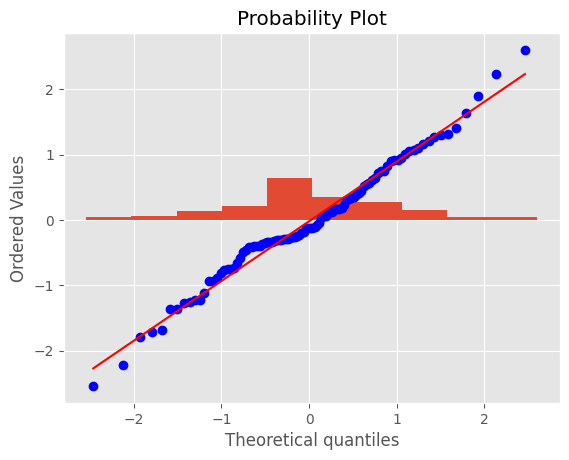

In [18]:
from scipy import stats

# Generate some random data
returns = np.random.normal(loc=0, scale=1, size=100)

# Plot histogram
plt.hist(returns, bins=10, density=True)

# Create Q-Q plot
stats.probplot(returns, dist="norm", plot=plt)

# Perform Shapiro-Wilk test
shapiro_test_statistic, shapiro_p_value = stats.shapiro(returns)

# Perform Anderson-Darling test
anderson_test_statistic, anderson_critical_values, anderson_significance_levels = stats.anderson(returns)

# Perform Kolmogorov-Smirnov test
ks_test_statistic, ks_p_value = stats.kstest(returns, 'norm')

# Perform Jarque-Bera test
jarque_bera_test_statistic, jarque_bera_p_value = stats.jarque_bera(returns)

# Print the test results
print("Shapiro-Wilk Test p-value:", shapiro_p_value)
print("Anderson-Darling Test Statistic:", anderson_test_statistic)
print("Anderson-Darling Critical Values:", anderson_critical_values)
print("Kolmogorov-Smirnov Test p-value:", ks_p_value)
print("Jarque-Bera Test Statistic:", jarque_bera_test_statistic)
print("Jarque-Bera Test p-value:", jarque_bera_p_value)

# Show the plots
plt.show()

None of these p-values are extremely small, which would indicate strong evidence against the normality assumption. However, they are not very large either, suggesting that the data may be approximately normally distributed.

In practice, the interpretation of normality tests depends on the context and the specific goals of the analysis. Additionally, normality is not always a strict requirement for some statistical analyses, especially when the sample size is large.

#Log transformation

Before diving in to the cointegration analyses on the crypto and stock market, we will first need to convert the two series into natural logs.

Transforming a variable using the natural logarithm can help stabilize its variance. This is particularly useful when dealing with heteroskedasticity, where the variability of the variable changes over time. Taking the logarithm can compress larger values and spread out smaller values, reducing the overall variance and making the data more homoskedastic.

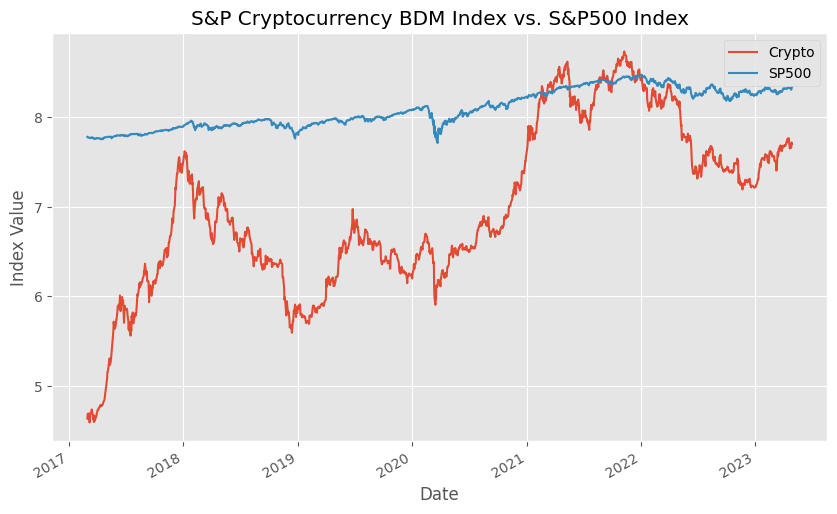

Correlation between S&P Cryptocurrency BDM Index and S&P500 Index: 0.8890817970657139


In [19]:
Crypto = dataset['Crypto']
Crypto_log = np.log(Crypto)
Indices = dataset[['Crypto', 'SP500']]
Indices_log = np.log(Indices)

# Plot the time series of both Crypto and Stock indices
Indices_log.plot(figsize=(10, 6))
plt.xlabel('Date')
plt.ylabel('Index Value')
plt.title('S&P Cryptocurrency BDM Index vs. S&P500 Index')
plt.show()

# Calculate the correlation between the two indices
correlation = Indices_log['Crypto'].corr(Indices_log['SP500'])
print(f'Correlation between S&P Cryptocurrency BDM Index and S&P500 Index: {correlation}')

Time series data has different characteristics that are used to define them. They can be either white noise variables, trending variables, or random walk variables.

Stock and crypto prices are usually random walks. It means that these data follow a stochastic trend, a non-stationary data that has a trend, but its values don't revolve around the mean, neither around some sort of trending line. These series have what we call an “infinite memory” and whenever a deviation happens, it never comes back to its mean.

Random walks are extremely chaotic and unpredictable, making it difficult to forecast. For that reason, when quantitative analysts work with financial data, they perform something called detrending, which is the process of removing the trend component from a time series.

In [20]:
Crypto_returns = return_dataset['Crypto']
Crypto_acf = acf_func(Crypto_returns, nlags = 50)

The Autocorrelation Function (ACF) is a statistical tool used to measure the correlation between a time series and its lagged versions. It calculates the correlation between the series at different lags (time points in the past). ACF is a useful tool to identify any significant pattern of correlation at different time lags.

ACF can tell us the following:


1.   Seasonality: If the ACF shows a repeating pattern at regular intervals, it indicates seasonality in the data. Seasonality refers to the presence of predictable patterns that repeat at fixed time intervals, such as daily, weekly, or monthly cycles.
2.   Autocorrelation: If the ACF shows a significant correlation at one or more lags, it suggests that the series is dependent on its past values, indicating autocorrelation.

3. Forecasting: ACF is useful in identifying the order of autoregressive (AR) terms in time series forecasting models like ARIMA. The significant lag(s) in the ACF can help determine the number of AR terms to include in the model.

4. Model Selection: ACF assists in identifying the appropriate lag(s) for a moving average (MA) component in ARIMA models. The significant lags in the ACF can help determine the number of MA terms to include in the model.


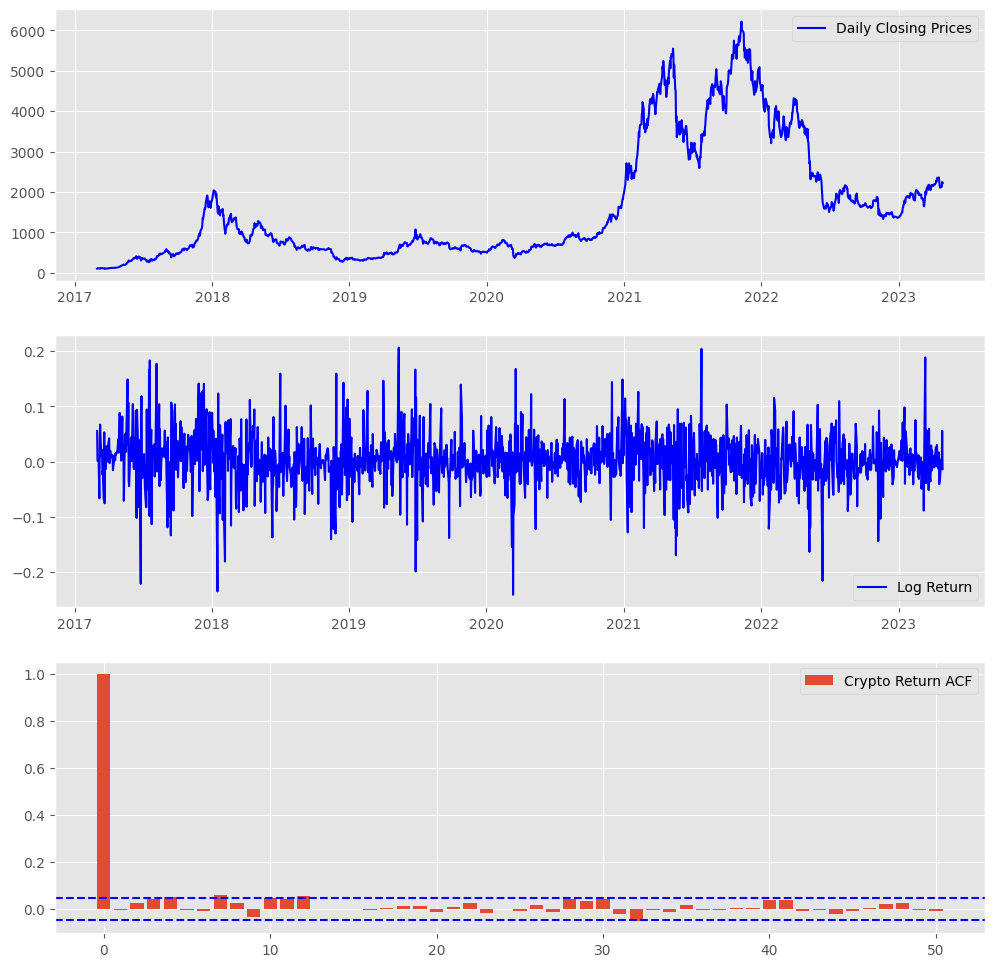

In [21]:
# Plotting the Daily Closing Prices of Crypto BDM Index
fig, ax = plt.subplots(figsize=(12,12), nrows=3, ncols=1)
ax[0].plot(dataset['Crypto'], label='Daily Closing Prices', color='blue')
ax[1].plot(Crypto_returns, label='Log Return', color='blue')

ax[2].bar(np.arange(len(Crypto_acf)), Crypto_acf, label='Crypto Return ACF')
ax[2].axhline(np.std(Crypto_acf[1:])*1.96, ls='--', color='b')
ax[2].axhline(-np.std(Crypto_acf[1:])*1.96, ls='--', color='b')
for i in range(3): ax[i].legend()
plt.show()

The positive autocorrelation of the crypto prices suggests that they are not random. This means that it is possible to predict the future price of crypto to some extent by looking at the past prices. However, the autocorrelation is not very strong, so it is not possible to make accurate predictions about the future prices.

#Stationarity test

##Augmented Dicker-Fuller (ADF) test

Next, a given time series is thought to consist of three systematic components including level, trend, seasonality, and one non-systematic component called noise.

These components are defined as follows:

* Level: The average value in the series.
* Trend: The increasing or decreasing value in the series.
* Seasonality: The repeating short-term cycle in the series.
* Noise: The random variation in the series.
First, we need to check if a series is stationary or not because time series analysis only works with stationary data.

The Dickey-Fuller test is one of the most popular statistical tests. It can be used to determine the presence of unit root in the series, and hence help us understand if the series is stationary or not. The null and alternate hypothesis of this test is:

Null Hypothesis: The series has a unit root (value of a =1)
Alternate Hypothesis: The series has no unit root.
If we fail to reject the null hypothesis, we can say that the series is non-stationary. This means that the series can be linear or difference stationary.

If both mean and standard deviation are flat lines(constant mean and constant variance), the series becomes stationary.

In [22]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue']
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")

In [23]:
from statsmodels.tsa.stattools import adfuller

for name, column in return_dataset.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "SP500" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -12.176
 No. Lags Chosen       = 8
 Critical value 1%     = -3.435
 Critical value 5%     = -2.863
 Critical value 10%    = -2.568
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "GBPJPY" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -26.4336
 No. Lags Chosen       = 1
 Critical value 1%     = -3.435
 Critical value 5%     = -2.863
 Critical value 10%    = -2.568
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "EURCAD" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    =

From the ADF test results, we can see that all of the returns variables are stationary.

#**Testing for Cointegration between the S&P Cryptocurrency BDM Index and the S&P500 Index**

Testing for cointegration between the S&P Cryptocurrency BDM Index and the S&P500 Index is essential when analyzing the long-term relationship and potential integration between these two time series. Cointegration is a statistical property that indicates whether two non-stationary time series have a long-term equilibrium relationship. In finance, cointegration is often used to study the relationship between financial assets, such as cryptocurrencies and stock market indices.

In [24]:
#Check for missing values:
print(Indices_log['SP500'].isnull().sum())
print(Indices_log['Crypto'].isnull().sum())

0
0


In [25]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
import warnings
warnings.simplefilter('ignore')
plt.style.use('ggplot')

Now let's test for stationarity in the Indices_log data.

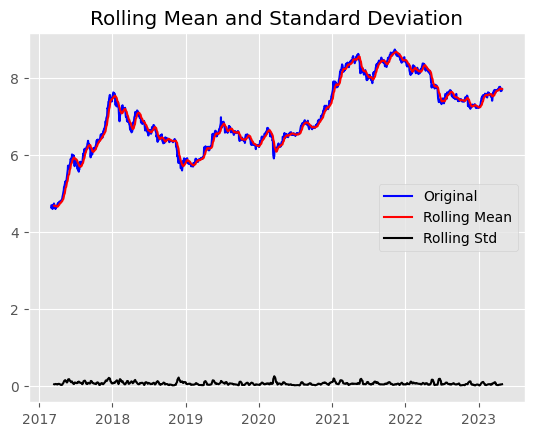

Results of dickey fuller test
Test Statistics                  -2.451112
p-value                           0.127827
No. of lags used                 12.000000
Number of observations used    1528.000000
critical value (1%)              -3.434637
critical value (5%)              -2.863433
critical value (10%)             -2.567778
dtype: float64


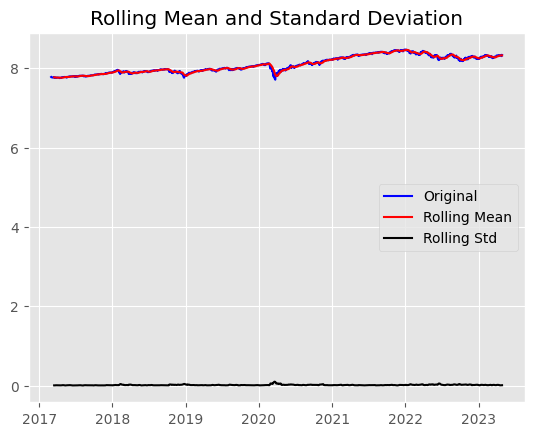

Results of dickey fuller test
Test Statistics                  -1.395311
p-value                           0.584522
No. of lags used                  9.000000
Number of observations used    1531.000000
critical value (1%)              -3.434628
critical value (5%)              -2.863430
critical value (10%)             -2.567776
dtype: float64


In [26]:
#Test for staionarity
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)

    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)

test_stationarity(Indices_log['Crypto'])
test_stationarity(Indices_log['SP500'])

<Figure size 640x480 with 0 Axes>

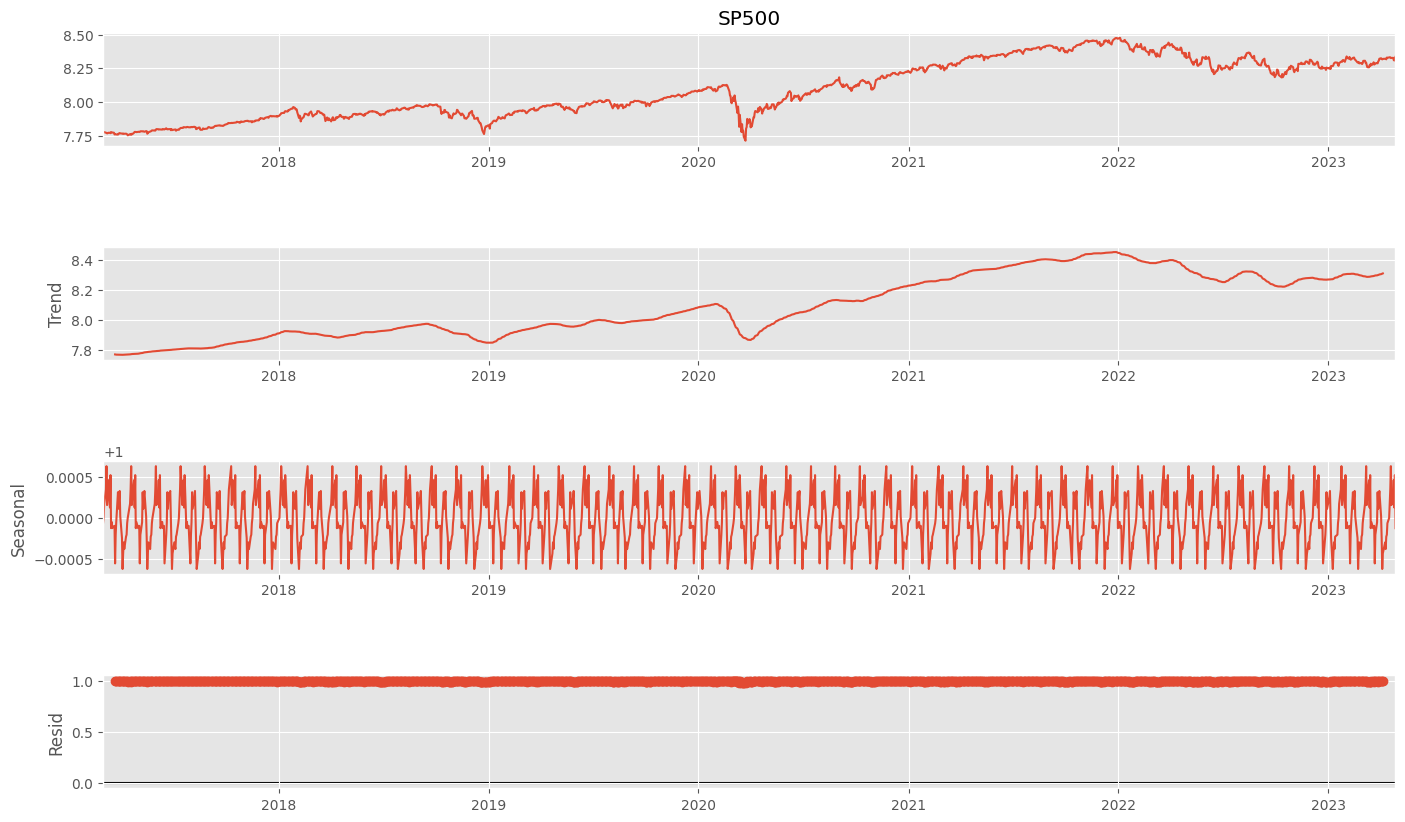

<Figure size 640x480 with 0 Axes>

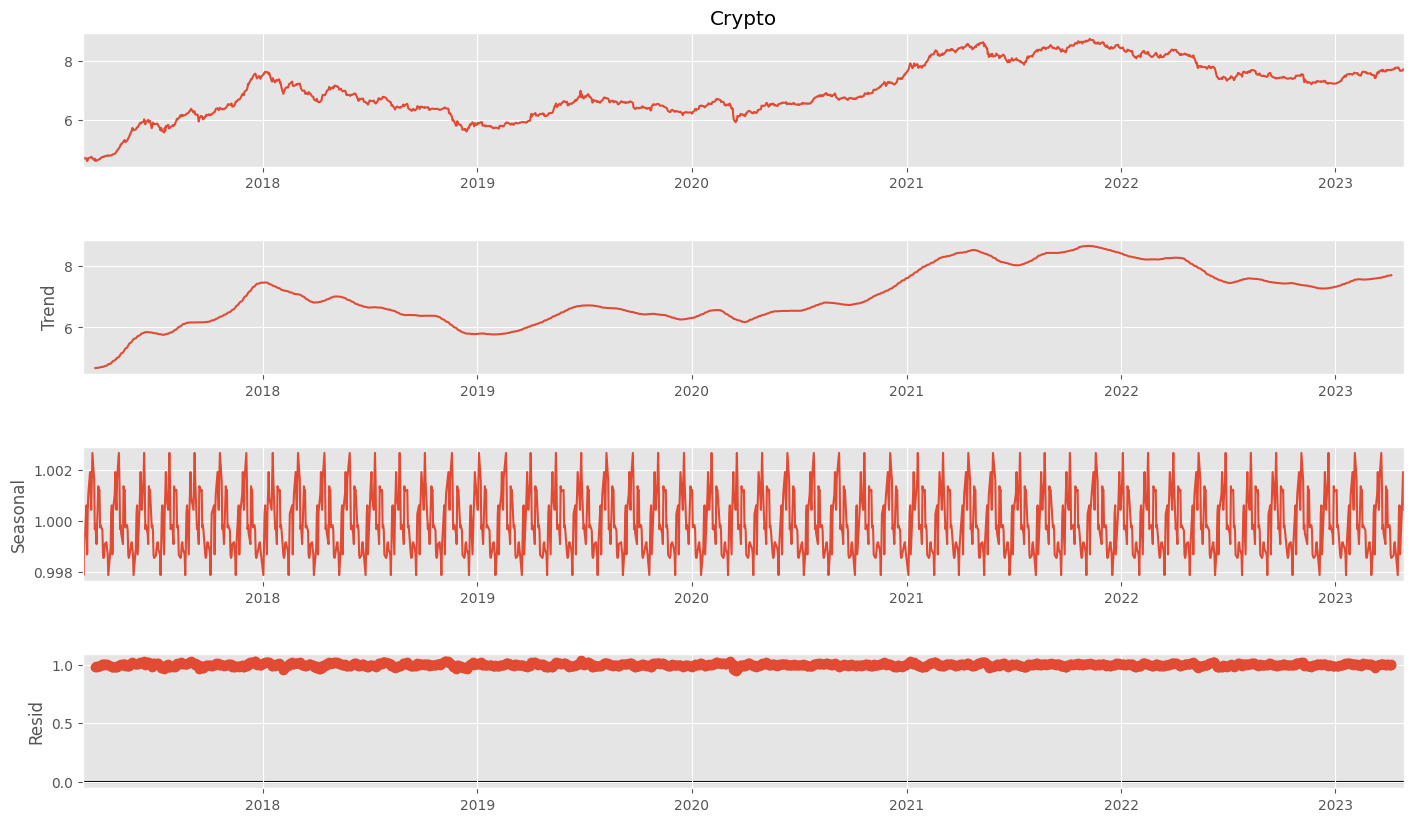

In [27]:
from statsmodels.tsa.seasonal import seasonal_decompose
sp500_decomposition = seasonal_decompose(Indices_log['SP500'], model='multiplicative', period=30)
sp500_trend = sp500_decomposition.trend
sp500_seasonal = sp500_decomposition.seasonal
sp500_residual = sp500_decomposition.resid
fig = plt.figure()
fig = sp500_decomposition.plot()
fig.set_size_inches(16, 9)

crypto_decomposition = seasonal_decompose(Indices_log['Crypto'], model='multiplicative', period=30)
crypto_trend = crypto_decomposition.trend
crypto_seasonal = crypto_decomposition.seasonal
crypto_residual = crypto_decomposition.resid
fig = plt.figure()
fig = crypto_decomposition.plot()
fig.set_size_inches(16, 9)

From the plot above we can see the seasonal component of the data, and we can also see the separated upward trend of the data.

Trends can be upward or downward, and can be linear or non-linear. Irregular fluctuations are abrupt changes that are random and unpredictable. Let's try to detrend the series before moving forward to the Johansen cointegration test.

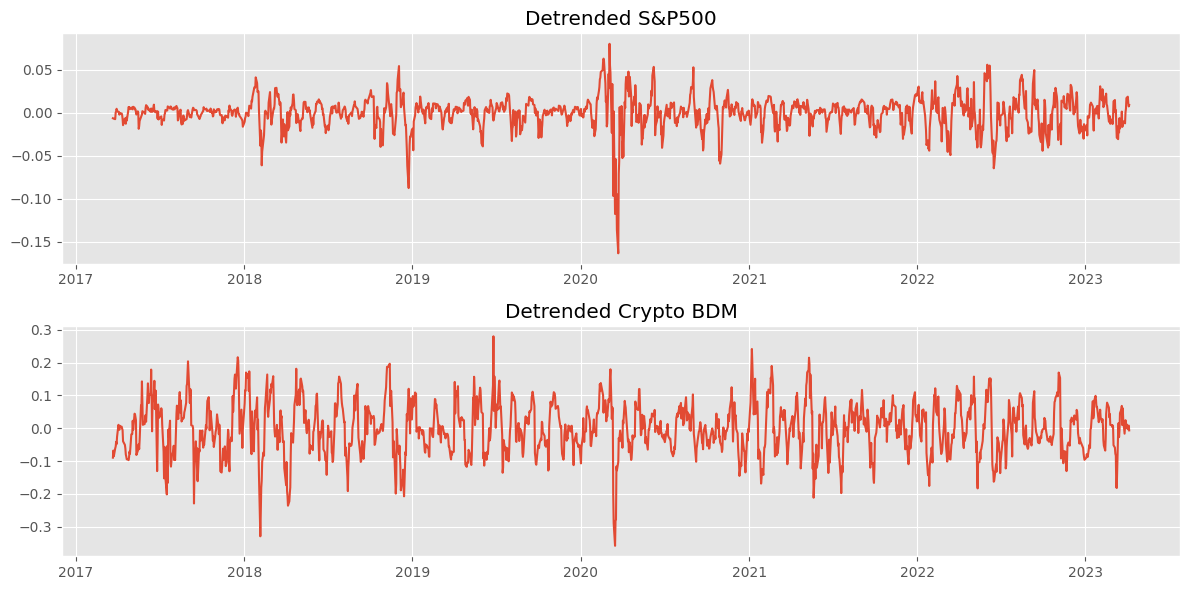

In [28]:
# Detrend sp500
detrended_sp500 = Indices_log['SP500'] - sp500_trend

# Detrend crypto
detrended_crypto = Indices_log['Crypto'] - crypto_trend

# Plot the detrended series
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(detrended_sp500)
plt.title('Detrended S&P500')
plt.subplot(2, 1, 2)
plt.plot(detrended_crypto)
plt.title('Detrended Crypto BDM')
plt.tight_layout()
plt.show()

In [29]:
detrended_sp500 = detrended_sp500.dropna()
detrended_crypto = detrended_crypto.dropna()

print(detrended_sp500.isnull().sum())
print(detrended_sp500.isnull().sum())

0
0


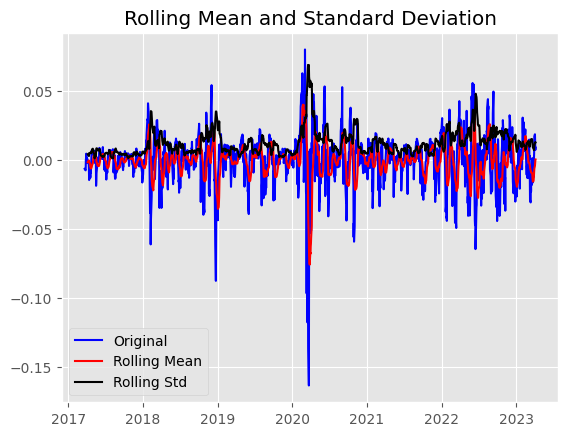

Results of dickey fuller test
Test Statistics               -1.168774e+01
p-value                        1.681205e-21
No. of lags used               2.200000e+01
Number of observations used    1.488000e+03
critical value (1%)           -3.434752e+00
critical value (5%)           -2.863484e+00
critical value (10%)          -2.567805e+00
dtype: float64


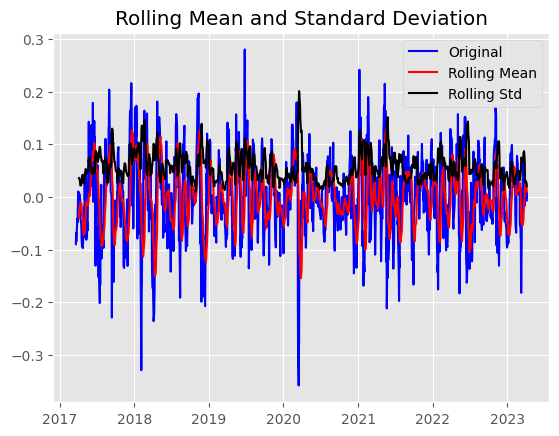

Results of dickey fuller test
Test Statistics               -1.279845e+01
p-value                        6.835402e-24
No. of lags used               1.200000e+01
Number of observations used    1.498000e+03
critical value (1%)           -3.434723e+00
critical value (5%)           -2.863471e+00
critical value (10%)          -2.567798e+00
dtype: float64


In [30]:
# Apply ADF test to the detrended series
test_stationarity(detrended_sp500)
test_stationarity(detrended_crypto)

In both cases, since the test statistics are more negative than the critical values and the p-values are significant, we have evidence to support the stationarity of the detrended series.

Let's apply the Johansen cointegration test to determine the presence and strength of cointegration between the cryptocurrency and stock index.

##Johansen Cointegration Test


The Johansen cointegration test is used to determine whether or not a set of time series are cointegrated. Cointegration is a concept in time series analysis that refers to the relationship between two or more non-stationary time series that have a long-term equilibrium relationship.

In [31]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

In [32]:
# Create a DataFrame with the detrended series
detrended_Indices = pd.concat([detrended_sp500, detrended_crypto], axis=1)
detrended_Indices.columns = ['Detrended_SP500', 'Detrended_Crypto']

# Print the merged detrended data
print(detrended_Indices.head())

            Detrended_SP500  Detrended_Crypto
Date                                         
2017-03-22        -0.006406         -0.089758
2017-03-23        -0.006733         -0.068156
2017-03-24        -0.006962         -0.085441
2017-03-27        -0.007508         -0.061304
2017-03-28         0.000166         -0.055911


In [33]:
# Perform Johansen cointegration test
result = coint_johansen(detrended_Indices, det_order=0, k_ar_diff=1)

In [34]:
# Print eigenvalues and critical values
print("Eigenvalues:")
print(result.eig)
print("\nCritical values (90%, 95%, 99%):")
print(result.cvt)

Eigenvalues:
[0.09878969 0.08402689]

Critical values (90%, 95%, 99%):
[[13.4294 15.4943 19.9349]
 [ 2.7055  3.8415  6.6349]]


The results of the Johansen cointegration test can be interpreted as follows:

* Eigenvalues:

The eigenvalues represent the characteristic roots of the cointegration matrix. In this case, the eigenvalues are [0.09878969 0.08402689]

An eigenvalue close to zero (or small) suggests the presence of cointegration between the cryptocurrency and stock index.

In this case, both eigenvalues are relatively small, indicating the possibility of cointegration between the two variables.


* Comparing the eigenvalues with the critical values:

The first eigenvalue is smaller than the critical values at all significance levels.

The second eigenvalue is also smaller than the critical values.

Based on these results, it suggests that there is evidence of cointegration between the cryptocurrency and stock index, indicating a long-term relationship between the two variables.

##Cointegration rank

The cointegration rank is the number of cointegration relations between a set of time series. The cointegration rank can be determined using the Johansen test or the Engle-Granger test.

In [35]:
rank_test = coint_johansen(detrended_Indices, det_order=0, k_ar_diff=3)
cointegration_rank = rank_test.eig

print("Cointegration rank:")
print(cointegration_rank)

# Print summary statistics
print("Johansen Cointegration Test Summary:")
print("-------------------------------")
print("Eigenvalues:")
print(rank_test.eig)
print("\nCritical values (90%, 95%, 99%):")
print(rank_test.cvm)

Cointegration rank:
[0.11174122 0.09700297]
Johansen Cointegration Test Summary:
-------------------------------
Eigenvalues:
[0.11174122 0.09700297]

Critical values (90%, 95%, 99%):
[[12.2971 14.2639 18.52  ]
 [ 2.7055  3.8415  6.6349]]


* Cointegration Rank:
The eigenvalues represent the rank of cointegration. In this case, we have two eigenvalues. The cointegration rank is determined by the number of eigenvalues that are statistically significant or greater than the corresponding critical values.

* Eigenvalues:
Both eigenvalues (0.11174122 0.09700297) are greater than the critical values at all confidence levels. This suggests that there are at least two cointegrating relationships present in the system. Each eigenvalue greater than the critical value indicates the existence of a cointegrating relationship.

* Critical Values:
The critical values represent the threshold for the test statistics at different confidence levels. For the maximum eigenvalue test, the first row represents the critical values. The second row represents the critical values for the trace test.

To summarize, based on the Johansen cointegration test results:

The system exhibits at least two cointegrating relationships.
The presence of cointegration implies a long-term relationship between the variables, indicating that they move together in the long run.

##Engle Granger test

The Engle-Granger test is a widely used method to test for cointegration between two variables. It helps confirm the long-term relationship between the variables and provides additional evidence to support the results obtained from the Johansen cointegration test and VECM modeling.

The Engle-Granger cointegration test considers the case that there is a single cointegrating vector. The test follows the very simple intuition that if variables are cointegrated, then the residual of the cointegrating regression should be stationary.

The test compares the null hypothesis of no cointegration against the alternative of cointegration.

In [36]:
from statsmodels.api import OLS
# Engle-Granger test for cointegration
def cointegration_test(y, x):
    model = OLS(y, x)
    result = model.fit()
    print(result.summary())

# Perform Engle-Granger test
print('\nEngle-Granger test:')
cointegration_test(detrended_sp500, detrended_crypto)


Engle-Granger test:
                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.107
Model:                            OLS   Adj. R-squared (uncentered):              0.107
Method:                 Least Squares   F-statistic:                              181.1
Date:                Thu, 10 Aug 2023   Prob (F-statistic):                    4.48e-39
Time:                        10:54:45   Log-Likelihood:                          3974.0
No. Observations:                1511   AIC:                                     -7946.
Df Residuals:                    1510   BIC:                                     -7941.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------

Based on the Engle-Granger test results, there is evidence of a cointegrating relationship between the variables. The coefficient estimate of the independent variable is statistically significant, indicating a meaningful relationship between the variables.

##Vector Error Correction Model (VECM)

* It is a multivariate time series model that extends the concept of an Error Correction Model (ECM) to multiple time series variables. The VECM is used to analyze the long-term and short-term dynamics among multiple variables that are potentially cointegrated.

* In a VECM, the cointegrated variables are modeled as a system of equations, where the current values of the variables depend on their own lagged values and the lagged values of the other variables in the system. The VECM incorporates the error correction term, which represents the adjustment mechanism that brings the variables back to their long-term equilibrium relationship when they deviate from it in the short term.

* The VECM is particularly useful when dealing with variables that have a long-term relationship but also exhibit short-term dynamics. It allows for the analysis of both the long-term equilibrium relationship (cointegration) and the short-term dynamics (error correction) among the variables. To estimate a VECM, various methods can be used, including maximum likelihood estimation.

* When fitting a VECM, it is generally recommended to use the detrended series. Detrending the series helps to remove any long-term trends or non-stationarity, allowing us to focus on the short-term dynamics and the relationship between the variables.

* By using the detrended series, we have to ensure that the VECM captures the short-term deviations from the long-term equilibrium, which is the essence of an error correction model. This approach helps in modeling the dynamic adjustment process and the speed of adjustment towards the long-term equilibrium relationship.

Therefore, it is advisable to use the detrended series when fitting a VECM model in order to obtain meaningful and accurate results.

In [37]:
from statsmodels.tsa.vector_ar.vecm import VECM

# Create the Indices of Crypto and S&P500 daily returns
Indices_returns = return_dataset[['Crypto', 'SP500']]

# Create the VECM model
model = VECM(Indices_returns, deterministic="ci", seasons=4, coint_rank=1)

# Fit the VECM model
vecm_res = model.fit()

# Print the summary of the VECM model
print(vecm_res.summary())

Det. terms outside the coint. relation & lagged endog. parameters for equation Crypto
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
season1       -0.0069      0.004     -1.715      0.086      -0.015       0.001
season2        0.0035      0.004      0.881      0.378      -0.004       0.011
season3        0.0049      0.004      1.224      0.221      -0.003       0.013
L1.Crypto     -0.3114      0.026    -11.901      0.000      -0.363      -0.260
L1.SP500      -1.0690      0.108     -9.913      0.000      -1.280      -0.858
Det. terms outside the coint. relation & lagged endog. parameters for equation SP500
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
season1       -0.0018      0.001     -1.825      0.068      -0.004       0.000
season2       -0.0006      0.001     -0

The VECM results suggest that there are short-run dynamics between the 'Crypto' and 'SP500' variables, and there is a long-run relationship between these variables, meaning they are cointegrated. The coefficients help quantify the strength and direction of these relationships.

Additionally, the results suggest that the Crypto and SP500 returns tend to move in opposite directions. This means that when the Crypto returns go up, the SP500 returns tend to go down.

Impulse-Response-Analysis

To analyze how an impulse in one variable affects the system, we can use the irf() method and call the returned object's plot method.

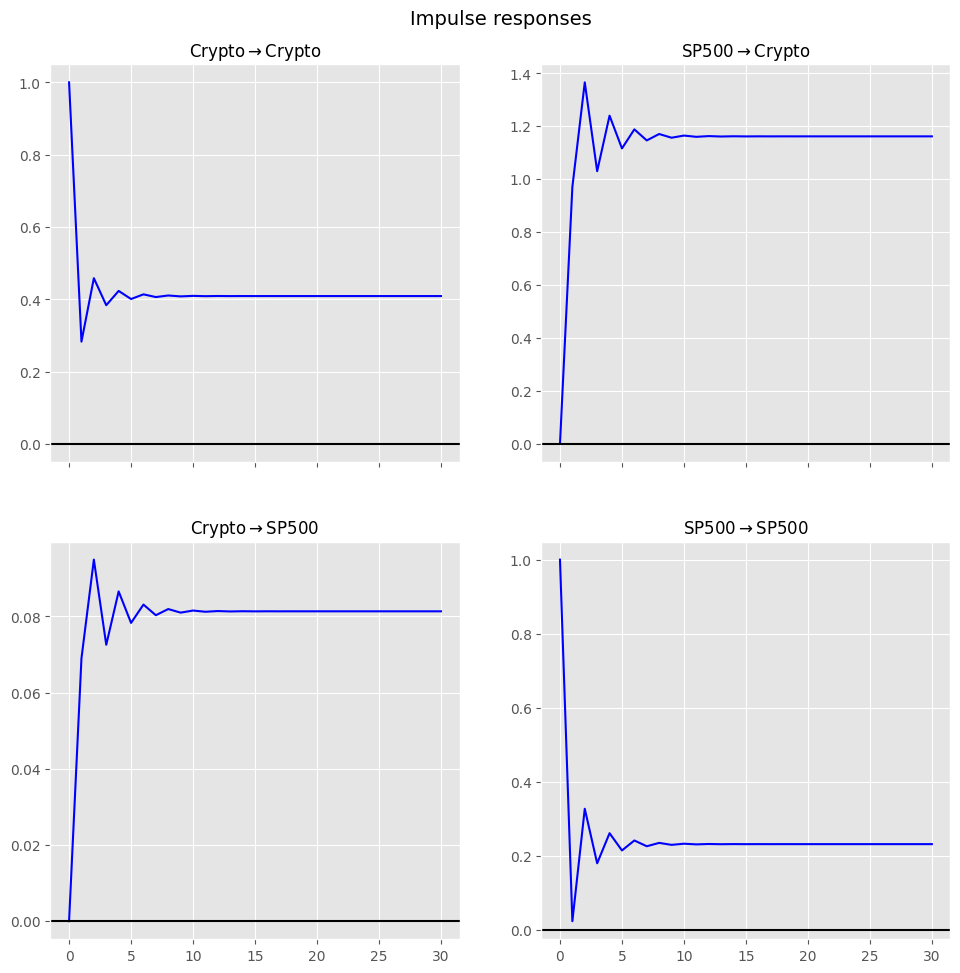

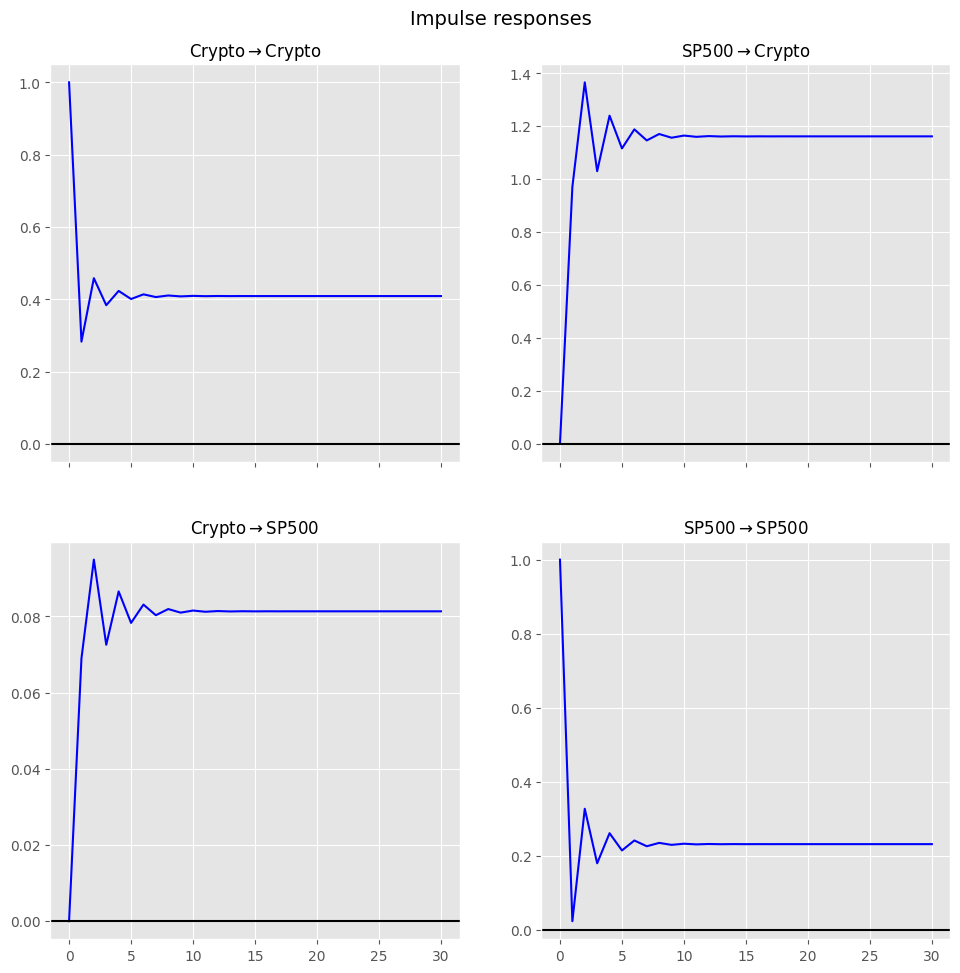

In [38]:
from statsmodels.tsa.vector_ar import irf
num_periods = 30
ir = vecm_res.irf(periods=num_periods)
ir.plot(plot_stderr=False)

The impulse response suggests that the cryptocurrency price is more responsive to positive shocks to the stock prices than to negative shocks. This means that if the S&P500 suddenly increases, the price of Crypto BDM is likely to increase as well. However, if the S&P500 suddenly decreases, the Crypto BDM is likely to decrease less than it would if the shock was positive.

#Modelling Volatility: ARCH and GARCH Models

In Econometrics, the ARCH (Autoregressive Conditional Heteroskedasticity) model is a statistical model used for time series data that exhibit volatility clustering, which suggests that periods of high volatility interspersed with periods of low volatility. Heteroskedasticity is a statistical term that describes a situation where the variation of residuals in a regression model is not the same across all levels of the independent variable.

Before evaluating if it's adequate to use ARCH models to model volatility for the Cryptocurrency data, we need to test the ARCH effect on the data. In the code below, we fit a GARCH model to the data, and then we obtain the squared residuals of the model to test if there are or not heteroskedasticity in the data. If the p-value is below 0.05, it means that the ARCH effect is present in the data, and we can use ARCH models to forecast volatility.

##ARCH effect



In [39]:
!pip install arch
import arch

In [40]:
# Testing for the ARCH effect
Crypto_returns = return_dataset['Crypto']
model = arch.arch_model(Crypto_returns, vol = 'GARCH', p = 1, q = 1, rescale = False)
results = model.fit(disp='off',show_warning = False)
residuals = results.resid
squared_residuals = residuals**2
arch_test = sm.stats.diagnostic.het_arch(squared_residuals)
print(f'ARCH test results:\n')
print(f'LM Statistic: {arch_test[0]}')
print(f'p-value: {arch_test[1]}')
print(f'F Statistic: {arch_test[2]}')
print(f'p-value: {arch_test[3]}')

ARCH test results:

LM Statistic: 10.109427505094713
p-value: 0.4309458995105955
F Statistic: 1.0103503935175793
p-value: 0.43206506049335947


The Autoregressive Conditional Heteroscedasticity (ARCH) test is used to assess whether there is evidence of conditional heteroscedasticity in the residuals, which implies that the volatility of the series varies over time.

The p-values (around 0.43) associated with both the LM statistic and the F statistic are larger than the conventional significance level of 0.05. This suggests that there is insufficient evidence to reject the null hypothesis of no ARCH effects. Therefore, based on the ARCH test results, it may conclude that there is no significant evidence of conditional heteroscedasticity in the squared residuals of the model.

In [41]:
# Fitting ARCH(1) model
model = arch.arch_model(Crypto_returns,
                       vol = 'ARCH',
                       p = 1, # One lag of the squared residuals
                       rescale = False)
results = model.fit(disp = 'off', show_warning = False)
print(results.summary()) # Plotting summary

                      Constant Mean - ARCH Model Results                      
Dep. Variable:                 Crypto   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:                2488.75
Distribution:                  Normal   AIC:                          -4971.50
Method:            Maximum Likelihood   BIC:                          -4955.48
                                        No. Observations:                 1540
Date:                Thu, Aug 10 2023   Df Residuals:                     1539
Time:                        10:55:03   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu         3.3931e-03  1.219e-03      2.785  5.360e-03 [1.

The ARCH(1) model suggests that the cryptocurrency price exhibits volatility clustering, where periods of high volatility tend to be followed by periods of high volatility, and vice versa. The model captures this behavior by incorporating the squared residuals as a proxy for volatility in the conditional variance equation.

In [42]:
# Fitting ARCH(2) model
model = arch.arch_model(Crypto_returns,
                       vol = 'ARCH',
                       p = 2, # Two lags of the squared residuals
                       rescale = False)
results = model.fit(disp = 'off', show_warning = False)
print(results.summary())

                      Constant Mean - ARCH Model Results                      
Dep. Variable:                 Crypto   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:                2515.57
Distribution:                  Normal   AIC:                          -5023.14
Method:            Maximum Likelihood   BIC:                          -5001.78
                                        No. Observations:                 1540
Date:                Thu, Aug 10 2023   Df Residuals:                     1539
Time:                        10:55:03   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu         2.8836e-03  1.181e-03      2.441  1.464e-02 [5.

The ARCH(2) model captures the volatility dynamics with statistically significant p-values on the lag-one and lag-two term.

##GARCH (1,1) Volatility model

We first created an ARCH model object with the desired specifications, such as specifying the volatility model as 'GARCH' and setting the order of the ARCH and GARCH components (p=1 and q=1). Then, we fit the model using the fit method.

After fitting the model, we can access various properties of the results, such as the summary of the model, the estimated parameters, and their significance. The params attribute provides the estimated parameters, and we can access individual parameter values using the parameter names (e.g., "omega", "alpha[1]", "beta[1]").

In [43]:
# Create a GARCH(1,1) model
model = arch.arch_model(Crypto_returns, vol='Garch', p=1, q=1)

# Fit the model
results = model.fit(disp='off')

# Get the ARCH coefficients
arch_coefs = results.params[1:-1]

# Check if all ARCH coefficients are positive
if all(arch_coefs > 0):
    print('The volatility of Crypto_returns is explosive.')
else:
    print('The volatility of Crypto_returns is not explosive.')

The volatility of Crypto_returns is explosive.


It is safe to say that:
* Explosive volatility can make it difficult to predict the future price of a cryptocurrency.
* Explosive volatility can make the market more risky for investors.
* Investors should carefully consider their risk tolerance before investing in a cryptocurrency with explosive volatility.

In [44]:
# Rescaling data by multiplying it for 100
Crypto_returns = Crypto_returns * 100

In [45]:
# Fit a GARCH(1, 1) model
model = arch.arch_model(Crypto_returns, vol='Garch', p=1, q=1)
results = model.fit()

# Print the model summary
print(results.summary())

# Access model parameters
print(f'ARCH parameter: {results.params["omega"]}')
print(f'GARCH parameter: {results.params["alpha[1]"]}')
print(f'Constant parameter: {results.params["beta[1]"]}')

Iteration:      1,   Func. Count:      6,   Neg. LLF: 7731.049128210589
Iteration:      2,   Func. Count:     13,   Neg. LLF: 81909189.3769264
Iteration:      3,   Func. Count:     19,   Neg. LLF: 279746548.3402446
Iteration:      4,   Func. Count:     25,   Neg. LLF: 4585.551647928687
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4564.509357566121
Iteration:      6,   Func. Count:     37,   Neg. LLF: 4566.154663884781
Iteration:      7,   Func. Count:     43,   Neg. LLF: 4564.377954241423
Iteration:      8,   Func. Count:     48,   Neg. LLF: 4564.37795332769
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4564.37795332769
            Iterations: 8
            Function evaluations: 48
            Gradient evaluations: 8
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                 Crypto   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:       

The GARCH (Generalized Autoregressive Conditional Heteroskedasticity) model provides insights into the volatility of the 'Crypto' variable.

Our GARCH(1,1) model conveys the important information as below:

1. Mean Model:
   - The mean model is a "Constant Mean" model, indicating that the expected value of 'Crypto' does not depend on past values of the series.

2. Volatility Model:
   - The GARCH model represents the volatility (standard deviation) of 'Crypto' as a function of past squared residuals (arch terms).
   - The parameters of the volatility model are as follows:
     - The intercept (omega) is 1.6380, but it is not statistically significant (p-value > 0.05), suggesting that the conditional variance has no significant intercept (mean effect).
     - The coefficient of the squared lagged residuals (alpha[1]) is 0.0750, and it is statistically significant (p-value < 0.05), indicating the presence of autoregressive conditional heteroskedasticity in the series.
     - The coefficient of the lagged conditional variance (beta[1]) is 0.8559, and it is statistically significant (p-value < 0.05), indicating a significant impact of past conditional variance on the current volatility.

3. Log-Likelihood and Information Criteria:
   - The log-likelihood value is -4564.38.
   - The Akaike Information Criterion (AIC) is 9136.76, and the Bayesian Information Criterion (BIC) is 9158.11. These criteria are used to compare models, and lower values indicate better-fitting models.

4. Volatility of 'Crypto':
   - The volatility of 'Crypto' can be estimated using the GARCH model.
   - The GARCH model provides time-varying volatility, where the conditional variance is updated with each new observation.

In summary, the GARCH model indicates that the volatility of 'Crypto' is influenced by its past squared residuals, and past conditional variance. The model can be used to estimate time-varying volatility, which is crucial for risk management and financial forecasting purposes.

#**Crypto Price Prediction**

##ARIMA model
Autoregressive Integrated Moving Average (ARIMA) model has been used extensively in the field of finance and economics as it is known to be robust, efficient and has a strong potential for short-term share market prediction.

The statsmodels library provides the capability to fit an ARIMA model. An ARIMA model can be created using the statsmodels library as follows:

Define the model by calling ARIMA() and passing in the p, d, and q parameters. The model is prepared on the training data by calling the fit() function. Predictions can be made by calling the predict() function and specifying the index of the time or times to be predicted.


###Test and Train split

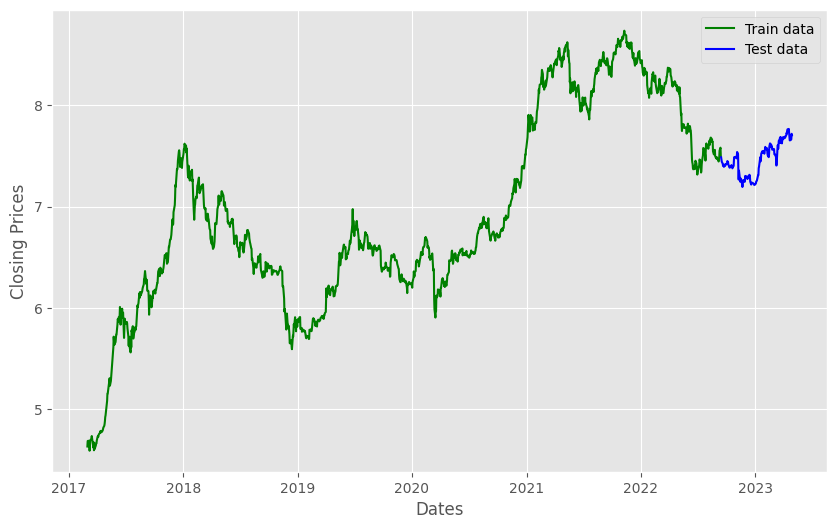

In [46]:
#Split the crypto closing prices data into train and training set

train_data = Crypto_log.iloc[:int(len(Crypto_log) * 0.9)]
test_data = Crypto_log.iloc[int(len(Crypto_log) * 0.9):]

plt.figure(figsize=(10, 6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(train_data, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()
plt.show()

An auto ARIMA model is a time series forecasting model that automatically determines the optimal order of the ARIMA model based on the data. ARIMA models are commonly used for time series forecasting, but selecting the appropriate values for the ARIMA hyperparameters (p, d, q) can be challenging and time-consuming, especially for non-experts.

The ARIMA model has three main hyperparameters:

1. p (order of autoregressive terms): The number of lag observations included in the model, which captures the relationship between the current value and its past values.

2. d (degree of differencing): The number of times the series needs to be differenced to achieve stationarity, which stabilizes the series' mean and variance over time.

3. q (order of moving average terms): The size of the moving average window, which captures the relationship between the current value and the past forecast errors.

The process of selecting the appropriate p, d, and q values can involve analyzing autocorrelation and partial autocorrelation plots, conducting statistical tests, and manual trial-and-error experimentation.

An auto ARIMA model automates this process by using algorithms to iteratively search for the best combination of p, d, and q values that minimize a specified evaluation criterion (e.g., AIC or BIC). The "auto" in auto ARIMA means that the model automatically determines the hyperparameters based on the input time series data, removing the need for manual selection.

 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=-3394.933, Time=0.30 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=-4351.690, Time=3.03 sec
 ARIMA(0,2,2)(0,0,0)[0] intercept   : AIC=-4349.875, Time=7.98 sec
 ARIMA(0,2,3)(0,0,0)[0] intercept   : AIC=inf, Time=6.79 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=-3824.085, Time=0.26 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=-4349.851, Time=7.79 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=6.17 sec
 ARIMA(1,2,3)(0,0,0)[0] intercept   : AIC=-4342.818, Time=7.38 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=-4003.172, Time=0.51 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=-4348.541, Time=5.25 sec
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=10.50 sec
 ARIMA(2,2,3)(0,0,0)[0] intercept   : AIC=inf, Time=5.92 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=-4102.732, Time=0.97 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=-4329.048, Time=8.04 sec
 ARIMA(3,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=8.70 sec

Best model:  ARIMA(0,2,

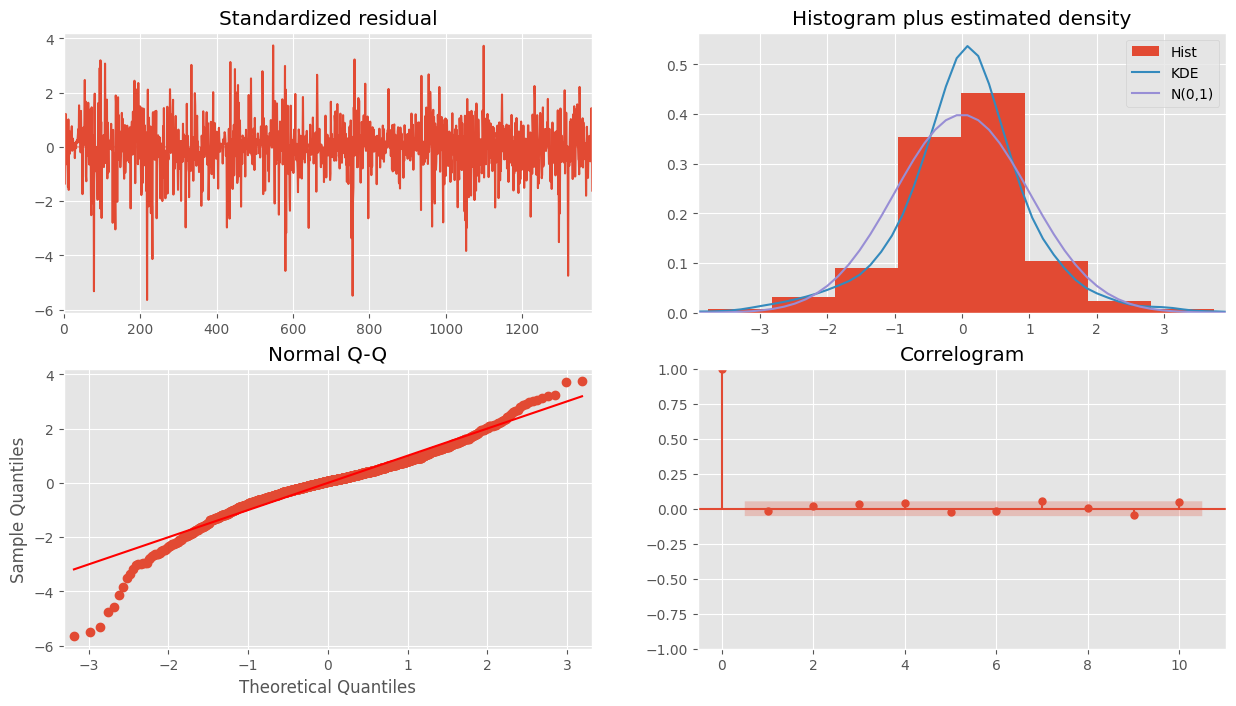

In [47]:
!pip install pmdarima
from pmdarima import auto_arima

# Fit Auto ARIMA model with specified parameters
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                            max_p=3, max_q=3,  # maximum p and q
                            m=1,               # frequency of series
                            d=2,               # determine 'd' 2nd diff
                            seasonal=False,    # No Seasonality
                            start_P=0,
                            D=1,
                            trace=True,
                            error_action='ignore',
                            suppress_warnings=True,
                            stepwise=False)

# Print the model summary
print(model_autoARIMA.summary())

# Plot model diagnostics
model_autoARIMA.plot_diagnostics(figsize=(15, 8))
plt.show()

The output provides the results of a SARIMA (Seasonal Autoregressive Integrated Moving Average) model.

Best Model: The best-fitting model is a SARIMA(0,2,1) model with no seasonal components (denoted as [0]) and an intercept term.

Log Likelihood: The log likelihood of the model is 2178.845. The log likelihood measures how well the model fits the data, and higher values indicate a better fit.

Akaike Information Criterion (AIC): The AIC is a model selection criterion that balances the goodness of fit with the complexity of the model. Lower AIC values are preferred, and in this case, the AIC is -4351.690.

Bayesian Information Criterion (BIC): The BIC is another model selection criterion that penalizes model complexity more strongly than the AIC. Like the AIC, lower BIC values are preferred, and here it is -4335.992.

Diagnostic Tests: The Ljung-Box test assesses the presence of autocorrelation in the residuals of the model, while the Jarque-Bera test assesses the normality of the residuals. A low p-value for the Ljung-Box test and a significant p-value for the Jarque-Bera test can indicate inadequacies in the model fit.

Heteroskedasticity: The model shows evidence of heteroskedasticity with a p-value of 0.75.

Overall, the SARIMA(0,2,1) model appears to provide a reasonably good fit to the data, although further diagnostics and evaluation of model assumptions may be necessary to assess its performance and suitability for the specific data set.

In [48]:
import statsmodels.api as sm
model = sm.tsa.ARIMA(train_data, order=(0, 2, 1))
fitted = model.fit()
print(fitted.summary())

                               SARIMAX Results                                
Dep. Variable:                 Crypto   No. Observations:                 1386
Model:                 ARIMA(0, 2, 1)   Log Likelihood                2178.584
Date:                Thu, 10 Aug 2023   AIC                          -4353.167
Time:                        10:56:31   BIC                          -4342.702
Sample:                             0   HQIC                         -4349.253
                               - 1386                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9892      0.004   -265.236      0.000      -0.997      -0.982
sigma2         0.0025   5.73e-05     43.769      0.000       0.002       0.003
Ljung-Box (L1) (Q):                   0.27   Jarque-

In [49]:
result = fitted.get_forecast(155, alpha =0.05).summary_frame()
print(result)
fc_series = pd.Series(result['mean'].values, index=test_data.index)
lower_series = pd.Series(result['mean_ci_lower'].values, index=test_data.index)
upper_series = pd.Series(result['mean_ci_upper'].values, index=test_data.index)

Crypto      mean   mean_se  mean_ci_lower  mean_ci_upper
1386    7.493294  0.050060       7.395179       7.591409
1387    7.489665  0.071178       7.350157       7.629172
1388    7.486035  0.087646       7.314252       7.657817
1389    7.482405  0.101749       7.282981       7.681829
1390    7.478775  0.114368       7.254618       7.702932
...          ...       ...            ...            ...
1536    6.948812  1.150454       4.693963       9.203661
1537    6.945182  1.157967       4.675608       9.214756
1538    6.941552  1.165493       4.657228       9.225876
1539    6.937922  1.173031       4.638823       9.237021
1540    6.934292  1.180583       4.620392       9.248192

[155 rows x 4 columns]


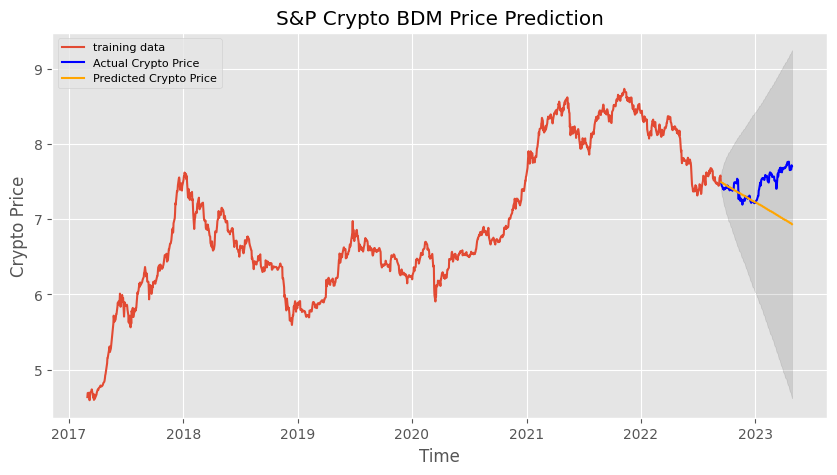

In [50]:
# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training data')
plt.plot(test_data, color = 'blue', label='Actual Crypto Price')
plt.plot(fc_series, color = 'orange',label='Predicted Crypto Price')
plt.fill_between(lower_series.index, lower_series, upper_series,
                 color='k', alpha=.10)
plt.title('S&P Crypto BDM Price Prediction')
plt.xlabel('Time')
plt.ylabel('Crypto Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

###Model Evaluation

In [51]:
import math
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mse = mean_squared_error(test_data, fc_series)
print('MSE: '+str(mse))
mae = mean_absolute_error(test_data, fc_series)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(test_data, fc_series))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(fc_series - test_data)/np.abs(test_data))
print('MAPE: '+str(mape))
r2 = r2_score(test_data, fc_series)
print('R2: '+str(r2))

MSE: 0.14858309390022714
MAE: 0.2777365447438336
RMSE: 0.3854647764715048
MAPE: 0.036546894995162706
R2: -5.093920303852013


##Vector Auto-Regressive (VAR) model

It is a statistical model that is used to describe the relationship between multiple time series. A VAR model is a generalization of the autoregressive model (AR), which is a model that is used to describe the relationship between a single time series and its own past values.

Previously, we have confirmed that our data is stationary, the next steps involve estimating and fitting the Vector Autoregressive (VAR) model on the training data.

Determine the appropriate lag order: The lag order specifies the number of previous time steps to include as predictors in the VAR model. We can use various methods like the Akaike Information Criterion (AIC), Bayesian Information Criterion (BIC), or information criteria to determine the optimal lag order.

Fit the VAR model: Use the VAR class from the statsmodels.tsa.vector_ar.var_model module to create an instance of the VAR model. Fit the model on the training data using the fit() method. Specify the lag order determined in the previous step as the input parameter.

In [52]:
# Import Statsmodels
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic

from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.stats.stattools import durbin_watson
from statsmodels.tsa.stattools import acf

### Test and Train split

In [53]:
nobs = 15
df_train, df_test = return_dataset[0:-nobs], return_dataset[-nobs:]

# Check size
print(df_train.shape)
print(df_test.shape)

(1525, 8)
(15, 8)


###Building the Model

In [54]:
model = VAR(return_dataset)
x = model.select_order(maxlags=12)
x.summary()

,AIC,BIC,FPE,HQIC
0,-68.58,-68.55,1.647e-30,-68.57
1,-75.14,-74.88,2.340e-33,-75.04
2,-75.74,-75.27*,1.275e-33,-75.57
3,-75.90,-75.21,1.085e-33,-75.64
4,-76.03,-75.11,9.540e-34,-75.69
5,-76.15,-75.01,8.441e-34,-75.73
6,-76.34,-74.98,6.987e-34,-75.83*
7,-76.42,-74.83,6.454e-34,-75.83
8,-76.43*,-74.62,6.415e-34*,-75.75
9,-76.42,-74.38,6.472e-34,-75.66


From the above, we select 8 as both AIC and FPE are lowest at that lag. We could continue going further in lags but since BIC has its lowest at 2 and HQIC is the lowest at 6, we can stop at 12. Now, let's fit our VAR model

In [55]:
model_fitted = model.fit(8)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 10, Aug, 2023
Time:                     10:56:32
--------------------------------------------------------------------
No. of Equations:         8.00000    BIC:                   -74.6253
Nobs:                     1532.00    HQIC:                  -75.7621
Log likelihood:           41679.4    FPE:                6.37485e-34
AIC:                     -76.4359    Det(Omega_mle):     4.57194e-34
--------------------------------------------------------------------
Results for equation SP500
                       coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------------
const                     0.000722         0.000435            1.660           0.097
L1.SP500                 -0.141543         0.026870           -5.268           0.000
L1.GBPJPY                 0.056497         0

The Durbin-Watson test is used to detect the presence of autocorrelation in the residuals of a regression analysis. The test statistic ranges between 0 and 4, where a value close to 2 indicates no significant autocorrelation (i.e., the residuals are independent), a value below 2 suggests positive autocorrelation, and a value above 2 suggests negative autocorrelation.

In [56]:
out = durbin_watson(model_fitted.resid)

for col, val in zip(dataset.columns, out):
    print((col), ':', round(val, 2))

SP500 : 1.98
GBPJPY : 2.0
EURCAD : 2.0
AUDCNY : 1.99
Crypto : 2.0
Interest_Rates : 2.01
CPI : 2.01
EPU : 2.01


Since all the test statistics are very close to 2, it suggests that there is no significant autocorrelation present in the residuals of the regression analysis for each variable. This indicates that the residuals are approximately independent and do not exhibit a systematic pattern of correlation over time.

In [57]:
# Get the lag order
lag_order = model_fitted.k_ar

# Input data for forecasting
forecast_input = df_train.values[-lag_order:]

In [58]:
# Forecast
fc = model_fitted.forecast(y=forecast_input, steps=nobs)
df_forecast = pd.DataFrame(fc, index=dataset.index[-nobs:], columns=dataset.columns + '_1d')
df_forecast.tail()

,SP500_1d,GBPJPY_1d,EURCAD_1d,AUDCNY_1d,Crypto_1d,Interest_Rates_1d,CPI_1d,EPU_1d
Date,,,,,,,,
2023-04-24,-0.001012,0.000344,0.000018,-0.000198,0.000755,-0.001030,0.004890,0.003788
2023-04-25,0.000478,-0.000136,0.000267,-0.000397,0.000301,0.028330,0.004384,0.003712
2023-04-26,-0.000005,-0.000072,0.000075,-0.000244,-0.000557,0.003199,0.003278,0.003644
2023-04-27,-0.000557,-0.000051,0.000037,-0.000445,-0.000101,0.009715,0.003222,0.003575
2023-04-28,0.000655,-0.000004,0.000077,-0.000419,0.000970,0.020001,0.002982,0.003506


### Final prediction

Now let's predict into the future! We are now using the whole dataset to feed the model with 8 lags (as predetermined)

In [59]:
# Make final predictions
model = VAR(return_dataset)

In [60]:
# Select 10 steps (days) of prediction
steps = 10

model_fit = model.fit(8)

pred = model_fit.forecast(return_dataset.values[-model_fit.k_ar:], steps=steps)

In [61]:
pred_df = pd.DataFrame(pred,columns=['Crypto',
             'SP500',
             'GBPJPY',
             'EURCAD',
             'AUDCNY',
             'Interes_Rates',
             'CPI',
             'EPU'])
pred_df.index = pd.date_range(start=return_dataset.index[-1], periods=steps+1)[1:]

In [62]:
# Make predictions on the test dataset
forecast = model_fitted.forecast(df_test.values, len(df_test))

# Convert the forecasted values to a DataFrame
forecast_df = pd.DataFrame(forecast, index=df_test.index, columns=df_test.columns)

In [63]:
df = return_dataset.tail(100).copy()
fc = pred_df.copy()
dp = 'Crypto'

We observe that the forecast has a shape and a unique trend, which indicates that it's taking information to make the prediction. Much like we observed in the test vs forecast images earlier, the model seems to learn enough information from every time series to inform each unique time series forecast.

The variable selection and VAR model seem to have a robust performance in predicting the Crypto BDM index prices in the short term. Some future considerations would be to add time series sets and/or combine them for dimensionality reduction.

Further, it would be interesting to compare the model performance with some deep learning algorithms like LSTM or perhaps, with a simpler univariate time series model like SARIMA.

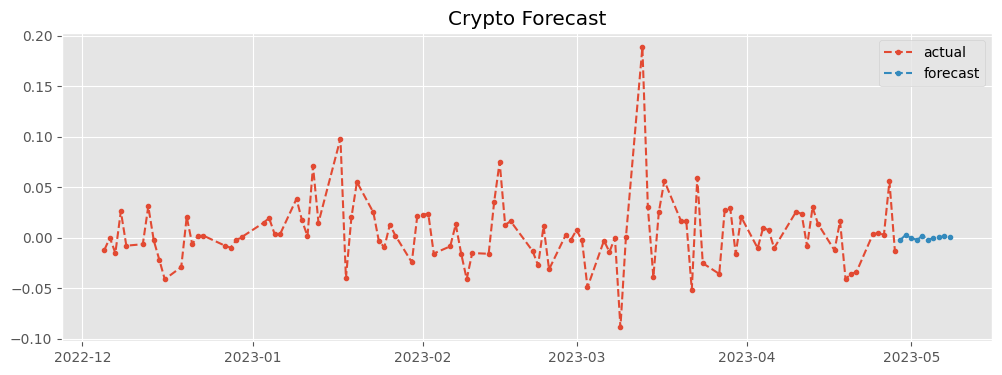

In [64]:
plt.figure(figsize=(12,4))
plt.plot(df.index, df[dp], label='actual',linestyle='dashed', marker='.')
plt.plot(fc.index, fc[[dp]], label='forecast',linestyle='dashed', marker='.')
plt.title(f"{dp} Forecast")
# plt.ylim(0.0,0.9)
plt.legend();

###Model Evaluation

In [65]:
# Calculate the Mean Absolute Error (MAE)
mae = np.mean(np.abs(forecast_df - df_test))

# Calculate the Mean Squared Error (MSE)
mse = np.mean((forecast_df - df_test) ** 2)

# Calculate the Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

# Calculate the Mean Absolute Percentage Error (MAPE)
mape = np.mean(np.abs(forecast_df - df_test)/np.abs(df_test))

# Calculate forecast errors
forecast_errors = forecast_df - df_test

# Calculate forecast bias
forecast_bias = forecast_errors.mean()

# Calculate forecast horizon
forecast_horizon = forecast_df.index[-1] - forecast_df.index[0]

# Print the evaluation metrics
print("Mean Absolute Error (MAE):\n", mae)
print("\nMean Squared Error (MSE):\n", mse)
print("\nRoot Mean Squared Error (RMSE):\n", rmse)
print("\nMean Absolute Percentage Error (MAPE):\n", mape)
print("\nForecast Errors:\n", forecast_errors)
print("\nForecast Bias:\n", forecast_bias)
print("\nForecast Horizon:\n", forecast_horizon)

Mean Absolute Error (MAE):
 SP500             0.006092
GBPJPY            0.003612
EURCAD            0.003969
AUDCNY            0.006043
Crypto            0.020710
Interest_Rates    0.022255
EPU               0.007684
CPI               0.001287
dtype: float64

Mean Squared Error (MSE):
 SP500             0.000072
GBPJPY            0.000020
EURCAD            0.000018
AUDCNY            0.000054
Crypto            0.000674
Interest_Rates    0.000953
EPU               0.000097
CPI               0.000002
dtype: float64

Root Mean Squared Error (RMSE):
 SP500             0.008476
GBPJPY            0.004489
EURCAD            0.004273
AUDCNY            0.007351
Crypto            0.025964
Interest_Rates    0.030877
EPU               0.009835
CPI               0.001319
dtype: float64

Mean Absolute Percentage Error (MAPE):
 SP500             6.113440
GBPJPY            0.944727
EURCAD            1.015609
AUDCNY            1.067995
Crypto            0.882720
Interest_Rates    2.774750
EPU           

In [66]:
# Calculate the total variance of the target variable (Crypto)
total_variance = np.var(df_test['Crypto'])

# Calculate the residual sum of squares (RSS)
residuals = forecast_df - df_test
rss = np.sum(residuals ** 2)

# Calculate the R-squared (variance explained)
r_squared = 1 - (rss / total_variance)

# Print the R-squared value
print("\nR-squared (Variance Explained):\n", r_squared)


R-squared (Variance Explained):
 SP500             -0.584931
GBPJPY             0.555378
EURCAD             0.597202
AUDCNY            -0.192240
Crypto           -13.872205
Interest_Rates   -20.032875
EPU               -1.133788
CPI                0.961598
dtype: float64


The R-squared values are negative, which is not possible for a valid R-squared. This suggests that the VAR model might not be a good fit for the data or there might be some issues with the model.

##Long Short Term Memory (LSTM)

Long Short-Term Memory (LSTM) is a type of recurrent neural network (RNN) that is well-suited for sequential data analysis and modeling. LSTM networks have gained popularity in stock market forecasting and time series prediction tasks for several reasons:

* Ability to capture long-term dependencies: LSTM networks are designed to handle and model long-term dependencies in sequential data. In the context of stock market forecasting, historical price patterns and trends can be captured and leveraged by LSTM networks to make predictions. This is particularly important as stock market data often exhibits complex and non-linear relationships that can extend over extended periods.

* Memory of past information: LSTM networks have a memory cell that allows them to retain and utilize information from previous time steps. This ability to remember and selectively forget information makes LSTMs well-suited for capturing and learning from past patterns and trends in stock market data.

* Handling of variable-length sequences: LSTM networks can handle variable-length input sequences, which is advantageous in stock market forecasting where the length of historical data may vary. By learning patterns from different time scales, LSTM models can potentially capture short-term fluctuations as well as long-term trends in the market.

* Feature extraction and representation learning: LSTM models can automatically learn relevant features and representations from raw data. This is beneficial in stock market forecasting, where the input data may consist of multiple variables, such as historical prices, trading volumes, and various market indicators. LSTMs can learn to extract important features and capture complex relationships among these variables to improve the forecasting performance.

* Non-linear modeling: LSTM networks can effectively model non-linear relationships and patterns in the data. This is crucial in stock market forecasting, as stock prices and market trends are influenced by a wide range of factors, including economic conditions, news events, investor sentiment, and external market forces. LSTMs can capture these non-linear dynamics and make predictions based on the learned patterns.

###Scaling the data

In [67]:
from sklearn.preprocessing import MinMaxScaler
# rescale the whole dataset (ideally this shoud be done seperately on the train and test data in order to prevent data leakage, in particular 'look-ahead bias')
scaler = MinMaxScaler(feature_range=(0, 1))
# train_series = scaler.fit_transform(train_series)
return_dataset['Crypto'] = scaler.fit_transform(return_dataset[['Crypto']])
scaled_data = return_dataset['Crypto']

In [68]:
from sklearn.preprocessing import MinMaxScaler

# Convert 'Crypto_returns' to a 2D array with a single feature
Crypto_returns_2d = Crypto_returns.values.reshape(-1, 1)

# Initialize MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

# Fit and transform the data
scaled_data = scaler.fit_transform(Crypto_returns_2d)

# Convert back to a pandas Series (if needed)
scaled_series = pd.Series(scaled_data.flatten(), index=Crypto_returns.index)

###Assigning Test and Train data

In [69]:
# Assign train data
X_train = train_data.index
y_train = train_data

# Assign test data
X_test = test_data.index
y_test = test_data

n_features = 1

train_series = y_train.values.reshape((len(y_train), n_features))
test_series = y_test.values.reshape((len(y_test), n_features))

###Building the Model

In [70]:
%%time

from keras.preprocessing.sequence import TimeseriesGenerator

look_back = 10

train_generator = TimeseriesGenerator(train_series, train_series,
                                      length        = look_back,
                                      sampling_rate = 1,
                                      stride        = 1,
                                      batch_size    = 10)

test_generator = TimeseriesGenerator(test_series, test_series,
                                      length        = look_back,
                                      sampling_rate = 1,
                                      stride        = 1,
                                      batch_size    = 10)

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

n_neurons  = 4
model = Sequential()
model.add(LSTM(n_neurons, input_shape=(look_back, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse');

model.fit(train_generator,epochs=300, verbose=0);

CPU times: user 5min 29s, sys: 9.17 s, total: 5min 38s
Wall time: 6min 31s


In [71]:
test_predictions  = model.predict(test_generator)

15/15 [==============================] - 1s 2ms/step


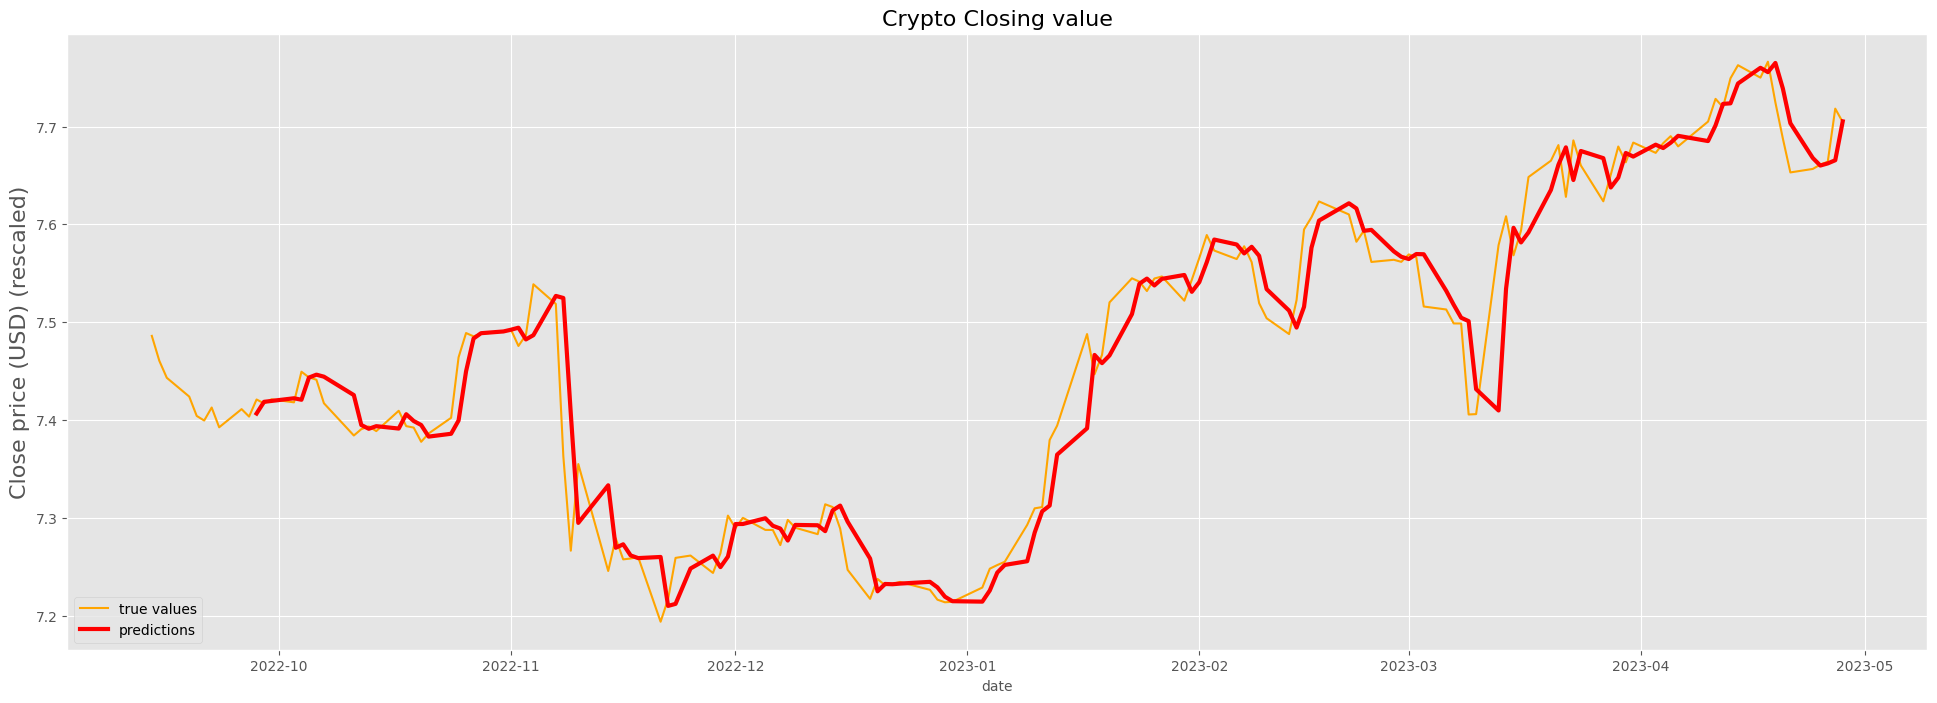

In [72]:
plt.figure(figsize=(24,8))
plt.plot(test_data.index, test_data, c='orange',label='true values')
plt.plot(X_test[10:],test_predictions, lw=3, c='r',linestyle = '-', label='predictions')
plt.legend(loc="lower left")
plt.xlabel("date", fontsize=10)
plt.ylabel("Close price (USD) (rescaled)", fontsize=16)
plt.title("Crypto Closing value", fontsize=16);

###Model Evaluation

In [73]:
# Calculate Mean Squared Error (MSE)
mse = np.mean((test_predictions - test_series[look_back:]) ** 2)

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

# Calculate Mean Absolute Error (MAE)
mae = np.mean(np.abs(test_predictions - test_series[look_back:]))

# Calculate Mean Absolute Percentage Error (MAPE)
mape = np.mean(np.abs(test_predictions - test_series[look_back:])/np.abs(test_series[look_back:]))

# Flatten the test_predictions and test_series arrays
test_predictions_flattened = test_predictions.flatten()
test_series_flattened = test_series[look_back:].flatten()

# Calculate R-squared (R2)
r2 = r2_score(test_series_flattened, test_predictions_flattened)

print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("Mean Absolute Error (MAE):", mae)
print("Mean Absolute Percentage Error (MAPE):", mape)
print("R-squared (R2):", r2)

Mean Squared Error (MSE): 0.0013770741583494681
Root Mean Squared Error (RMSE): 0.03710894984164154
Mean Absolute Error (MAE): 0.024014866109619403
Mean Absolute Percentage Error (MAPE): 0.0032151467241638087
R-squared (R2): 0.9467882984622503


##Naive model

A naive model is a simple statistical model that assumes that the future will be the same as the past. This is in contrast to a machine learning algorithm, which is a more complex model that learns from historical data to predict future values.

Let's create a naive model!

In [74]:
# create a naïve forecast
test_data['naive'] = test_data.shift(1)

In [75]:
# Convert the Crypto prices to numeric
test_data = pd.to_numeric(test_data, errors='coerce')

# Remove rows with NaN values
test_data = test_data.dropna()

# Extract the 'Crypto data as a numpy array
actual_prices = test_data.values

# Create a naive model by shifting the prices one step forward
naive_predictions = np.roll(actual_prices, -1)

# Calculate the metrics
naive_mse = mean_squared_error(actual_prices[:-1], naive_predictions[:-1])
naive_rmse = np.sqrt(naive_mse)
naive_mae = mean_absolute_error(actual_prices[:-1], naive_predictions[:-1])
naive_mape = np.mean(np.abs((actual_prices[:-1] - naive_predictions[:-1]) / actual_prices[:-1])) * 100
naive_r2 = r2_score(actual_prices[:-1], naive_predictions[:-1])

# Print the metrics
print("Naïve model MSE: %.4f" % naive_mse)
print("Naïve model RMSE: %.4f" % naive_rmse)
print("Naïve model MAE: %.4f" % naive_mae)
print("Naïve model MAPE: %.4f%%" % naive_mape)
print("Naïve model R2: %.4f" % naive_r2)

Naïve model MSE: 0.0012
Naïve model RMSE: 0.0351
Naïve model MAE: 0.0233
Naïve model MAPE: 0.3115%
Naïve model R2: 0.9490


As we can see, a Naive model easily beats the other predictive models. The question is, why?

There are a few reasons why a naive model might easily beat any machine learning algorithm in predicting stock prices.

* Market efficiency: The stock market is often said to be efficient,
which means that all available information is already reflected in the prices of stocks. If this is true, then a machine learning algorithm would not be able to predict future stock prices any better than a naive model that simply assumes that the future will be the same as the past.
* Data scarcity: There is a limited amount of historical data available for stock prices. This makes it difficult for machine learning algorithms to learn from the data and to make accurate predictions.
*Overfitting: Machine learning algorithms are often prone to overfitting, which means that they learn the training data too well and are not able to generalize to new data. This can lead to inaccurate predictions.

#**Determining the Significant Macroeconomic Variables**

In this section, we will be addressing the third research objective: To determine which macroeconomic variables impact cryptocurrency prices the most.

Our goal in this section is not to predict, as accurately as possible, the price of cryptocurrency tomorrow but to see how we can use a machine learning algorithm called Random Forest to create a model that can predict cryptocurrency prices using historical data.


##Random Forest

How does Random Forest work?


Random Forest will make use of decision trees to understand how these factors affected bitcoin prices in the past. Simply put, a decision tree is a flowchart-like mapping of inputs and outputs.

The patterns from these decision trees are what would dictate our price prediction model. The more data we can feed the Random Forest algorithm, the more opportunities it would have in finding new patterns and verifying existing patterns. It will then average the predictions of each tree to create a more reliable prediction. We will test how the predicted values fare out against the actual values. This means, we will save some data points from our dataset to test the predictions of the Random Forest algorithm.

* To perform a Random Forest training on our dataset, we assign the X and y variables. X will have all the columns that we are assuming to be factors affecting price, y.

In [76]:
features = ['SP500', 'GBPJPY', 'EURCAD', 'AUDCNY', 'Interest_Rates', 'CPI', 'EPU']
X = df[features]
y = df['Crypto']

Then we split the dataset into a training and testing or validation dataset. We need this so we can test how good our predictions are to the actual prices.

In [77]:
from sklearn.model_selection import train_test_split
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=1)

###Building the Model

In [78]:
from sklearn.ensemble import RandomForestRegressor
rf_model = RandomForestRegressor(random_state=1)

We now feed the training data to the Random Forest algorithm so it can map patterns or decision trees.

In [79]:
rf_model.fit(train_X, train_y)

RandomForestRegressor(random_state=1)

Once we have a model, we can call predict to predict the prices of cryptocurrency on our testing or validation data. That is, given that we’ve trained a model using train_X and train_y, we are now interested if it’d be able to ouput a number close to val_Y given val_X. Remember that we split the dataset earlier to a training dataset (train_X, train_Y) and a testing dataset (val_X, val_y).

In [80]:
rf_pred = rf_model.predict(val_X)

To see the predicted values of the model on the last 5 validation data, we can call:

In [81]:
print(rf_model.predict(X.tail()))
df['Crypto'].tail()

[ 0.0069223   0.00172637 -0.00209924  0.03873578 -0.00180132]


Date
2023-04-24    0.003569
2023-04-25    0.004431
2023-04-26    0.002957
2023-04-27    0.055734
2023-04-28   -0.013695
Name: Crypto, dtype: float64

Let’s see how far off the predicted values are from the actual values using MAE (Mean Absolute Error). This number will tell us how off are predictions are on average

In [82]:
from sklearn.metrics import mean_absolute_error
rf_val_mae = mean_absolute_error(val_y,rf_pred)
rf_val_mae

0.020319962250212806

MAE is telling us that on average, our cryptocurrency returns prediction is off by 0.0203 from the actual percentages.

Now let's determine which variables are crucial in price prediction.

In [83]:
# Get feature importances
importances = rf_model.feature_importances_

# Print feature importances
for i, importance in enumerate(importances):
    print('Feature', i+1, ':', df.columns[i+1], 'Importance:', importance)

Feature 1 : GBPJPY Importance: 0.20022593476136746
Feature 2 : EURCAD Importance: 0.06544795925727385
Feature 3 : AUDCNY Importance: 0.15101239225092356
Feature 4 : Crypto Importance: 0.0837037034180381
Feature 5 : Interest_Rates Importance: 0.3114670657990261
Feature 6 : EPU Importance: 0.07895762064292679
Feature 7 : CPI Importance: 0.10918532387044426


The importance values are all between 0 and 1, and they add up to 1, indicating the relative importance of each feature in the model. Here's what they tell us:

1. SP500 Importance (0.2002): The importance of the SP500 feature is 0.2002, which indicates that it contributes significantly to the predictive power of the model. This feature likely contains information related to the performance of the S&P 500 stock market index, and its impact on the target variable is notable.

2. GBPJPY Importance (0.0654): The GBPJPY feature has an importance of 0.0654. This suggests that the exchange rate between the British Pound and the Japanese Yen also plays a role in predicting the target variable, although its contribution is relatively lower compared to other features.

3. EURCAD Importance (0.1510): The EURCAD feature has an importance of 0.1510, indicating that the exchange rate between the Euro and the Canadian Dollar is a significant predictor. This feature likely captures economic relationships between the Eurozone and Canada.

4. AUDCNY Importance (0.0837): The AUDCNY feature has an importance of 0.0837. This feature represents the exchange rate between the Australian Dollar and the Chinese Yuan, contributing moderately to the model's predictive performance.

5. Interest_Rates Importance (0.3115): The most important feature in the model is "Interest_Rates" with an importance of 0.3115. This suggests that short-term interest rates have a substantial influence on the target variable. Changes in interest rates may impact various economic sectors, and the model has identified this as a key driver.

6. EPU Importance (0.0790): The Economic Policy Uncertainty (EPU) feature has an importance of 0.0790. EPU reflects the level of uncertainty in economic policies, and its influence on the target variable is noteworthy, albeit relatively lower compared to other features.

7. CPI Importance (0.1092): The Consumer Price Index (CPI) feature has an importance of 0.1092. CPI is a measure of inflation, and its impact on the target variable is significant. Changes in inflation rates can have implications for various economic decisions.

It appears that interest rates, economic uncertainty, inflation, and exchange rates are key drivers of our model's predictions, which aligns with economic intuition.

###Model Evaluation

In [84]:
# Calculate evaluation metrics
mae = mean_absolute_error(val_y, rf_pred)
mse = mean_squared_error(val_y, rf_pred)
rmse = np.sqrt(mse)
r2 = r2_score(val_y, rf_pred)

# Print evaluation results
print('Random Forest Regressor Model')
print(25 * '=')
print('Mean Absolute Error (MAE):', mae)
print('Mean Squared Error (MSE):', mse)
print('Root Mean Squared Error (RMSE):', rmse)
print('R-squared (R2):', r2)

Random Forest Regressor Model
Mean Absolute Error (MAE): 0.020319962250212806
Mean Squared Error (MSE): 0.0006184459682680095
Root Mean Squared Error (RMSE): 0.024868573909012346
R-squared (R2): -0.08530874261586163


# **Classifying Methods**

In this bonus section, we will further confirm the accuracy of our prediction for crypto prices with classification machine learning models (Logistic Regression, Random Forest Classifier, K Nearest Neighbors, Support Vector Classifier) to see if we can predict whether today's returns will be positive or negative based on the returns of the 5 previous days and we compare these models prediction accuracy.

In [85]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [86]:
classifier_df = pd.DataFrame()
classifier_df['Today'] = (Crypto/Crypto.shift(1))-1. # create the return
classifier_df['Lag1'] = classifier_df['Today'].shift(1)
classifier_df['Lag2'] = classifier_df['Today'].shift(2)
classifier_df['Lag3'] = classifier_df['Today'].shift(3)
classifier_df['Lag4'] = classifier_df['Today'].shift(4)
classifier_df['Lag5'] = classifier_df['Today'].shift(5)
classifier_df.dropna(inplace = True)
classifier_df

,Today,Lag1,Lag2,Lag3,Lag4,Lag5
Date,,,,,,
2017-03-09,0.038485,-0.066553,-0.028828,0.001287,0.001473,0.055280
2017-03-10,0.066901,0.038485,-0.066553,-0.028828,0.001287,0.001473
2017-03-13,0.011883,0.066901,0.038485,-0.066553,-0.028828,0.001287
2017-03-14,0.009033,0.011883,0.066901,0.038485,-0.066553,-0.028828
2017-03-15,0.021397,0.009033,0.011883,0.066901,0.038485,-0.066553
...,...,...,...,...,...,...
2023-04-24,0.003569,-0.033950,-0.036275,-0.040772,0.016408,-0.012637
2023-04-25,0.004431,0.003569,-0.033950,-0.036275,-0.040772,0.016408
2023-04-26,0.002957,0.004431,0.003569,-0.033950,-0.036275,-0.040772


Let's construct an additional column to our data frame to indicate whether on a given day the returns were positive or negative. If the returns were positive we label this with 1, and with 0 otherwise.

In [87]:
def direction(x):
    if x>0:
        return 1.0
    else:
        return 0.0

In [88]:
classifier_df['Direction'] = classifier_df['Today'].apply(direction)
classifier_df

,Today,Lag1,Lag2,Lag3,Lag4,Lag5,Direction
Date,,,,,,,
2017-03-09,0.038485,-0.066553,-0.028828,0.001287,0.001473,0.055280,1.0
2017-03-10,0.066901,0.038485,-0.066553,-0.028828,0.001287,0.001473,1.0
2017-03-13,0.011883,0.066901,0.038485,-0.066553,-0.028828,0.001287,1.0
2017-03-14,0.009033,0.011883,0.066901,0.038485,-0.066553,-0.028828,1.0
2017-03-15,0.021397,0.009033,0.011883,0.066901,0.038485,-0.066553,1.0
...,...,...,...,...,...,...,...
2023-04-24,0.003569,-0.033950,-0.036275,-0.040772,0.016408,-0.012637,1.0
2023-04-25,0.004431,0.003569,-0.033950,-0.036275,-0.040772,0.016408,1.0
2023-04-26,0.002957,0.004431,0.003569,-0.033950,-0.036275,-0.040772,1.0


We will now use machine learning models to try to predict whether the Crypto BDM index will have a positive return (labeled as 1) or a negative return (labeled as 1) based on the values of the returns from the 5 previous days. For this, we build our test and train data sets. We set the date 2018-01-01 as the begining of our test sets.

In [89]:
X = classifier_df[['Lag1','Lag2','Lag3','Lag4', 'Lag5']]
y = classifier_df['Direction']

In [90]:
start_test = pd.to_datetime('2018-01-01')

X_train = X[X.index < start_test]
X_test = X[X.index >= start_test]
y_train = y[y.index < start_test]
y_test = y[y.index >= start_test]

X_train.shape

(205, 5)

In [91]:
X_test.shape

(1330, 5)

##Logistic Regression

Let's implement the logistic regression model:

In [92]:
logmodel = LogisticRegression(C = 10.0,solver='lbfgs')
logmodel.fit(X_train,y_train)

LogisticRegression(C=10.0)

In [93]:
pred = logmodel.predict(X_test)
print('Logistic Regression Model')
print(25*'===')

print(classification_report(y_test,pred))
#print('\n')
print(25*'===')
print('Confusion Matrix')
print(confusion_matrix(y_test,pred))
print(25*'===')
print('Accuracy: ',logmodel.score(X_test,y_test).round(2))

Logistic Regression Model
              precision    recall  f1-score   support

         0.0       0.33      0.00      0.00       630
         1.0       0.53      1.00      0.69       700

    accuracy                           0.53      1330
   macro avg       0.43      0.50      0.35      1330
weighted avg       0.43      0.53      0.36      1330

Confusion Matrix
[[  1 629]
 [  2 698]]
Accuracy:  0.53


##Random Forest classifier

In [94]:
rfc = RandomForestClassifier(n_estimators=5000)
rfc.fit(X_train,y_train)

RandomForestClassifier(n_estimators=5000)

In [95]:
pred = rfc.predict(X_test)

In [96]:
print('Random Forest Classifier Model')
print(25*'===')

print(classification_report(y_test,pred))
#print('\n')
print(25*'===')
print('Confusion Matrix')
print(confusion_matrix(y_test,pred))
print(25*'===')
print('Accuracy: ',rfc.score(X_test,y_test).round(2))

Random Forest Classifier Model
              precision    recall  f1-score   support

         0.0       0.49      0.17      0.26       630
         1.0       0.53      0.84      0.65       700

    accuracy                           0.52      1330
   macro avg       0.51      0.51      0.45      1330
weighted avg       0.51      0.52      0.46      1330

Confusion Matrix
[[110 520]
 [113 587]]
Accuracy:  0.52


##K Nearest Neighbours

We start the implementation of this model with a number of  K=150  nearest neighbors.

In [97]:
knn = KNeighborsClassifier(n_neighbors=150)
knn.fit(X_train,y_train)

KNeighborsClassifier(n_neighbors=150)

In [98]:
pred = knn.predict(X_test)

In [99]:
print('KNN Model')
print(25*'===')

print(classification_report(y_test,pred))
#print('\n')
print(25*'===')
print('Confusion Matrix')
print(confusion_matrix(y_test,pred))
print(25*'===')
print('Accuracy: ',knn.score(X_test,y_test).round(2))

KNN Model
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       630
         1.0       0.53      1.00      0.69       700

    accuracy                           0.53      1330
   macro avg       0.26      0.50      0.34      1330
weighted avg       0.28      0.53      0.36      1330

Confusion Matrix
[[  0 630]
 [  0 700]]
Accuracy:  0.53


##Support Vector Classifier

In [100]:
model = SVC(gamma='scale')
model.fit(X_train,y_train)

SVC()

In [101]:
pred = model.predict(X_test)

In [102]:
print('SVC Model')
print(25*'===')

print(classification_report(y_test,pred))
#print('\n')
print(25*'===')
print('Confusion Matrix')
print(confusion_matrix(y_test,pred))
print(25*'===')
print('Accuracy: ',model.score(X_test,y_test).round(2))

SVC Model
              precision    recall  f1-score   support

         0.0       0.59      0.04      0.07       630
         1.0       0.53      0.98      0.69       700

    accuracy                           0.53      1330
   macro avg       0.56      0.51      0.38      1330
weighted avg       0.56      0.53      0.39      1330

Confusion Matrix
[[ 23 607]
 [ 16 684]]
Accuracy:  0.53


It may be concluded that all implemented models have an accuracy that does not exceed 0.53, which is nothing different than a flip coin. This phenomenon may be attributed to the nature of cryptocurrency prices, which exhibit a random walk. Consequently, the returns on a particular day are influenced by the preceding returns, with a diminishing effect that becomes more fast as time progresses. Furthermore, we have not accounted for any data that may provide insights on the normalcy of the distribution of returns.  